- 드라이샴푸, 스케일러 상품 제외

# 올영 데이터 분석 내용

- BERT 모델 후보
  
- 리뷰 데이터 길이 분석

- 문장 분리 여부

- 데이터 정제
    - soynlp 사용하여 띄어쓰기 오류 교정 및 중복 문자열 축약 등
    - PyKoSpacing 띄어쓰기 오류 교정

- 추가 전처리 내용

cf. 데이콘에서 모델링 기본 코드 제공해 줌

# BERT 모델 후보

- KoBERT
    - 대중적이나, 뉴스 등 정제된 데이터로 학습된 모델
    - 적합하지 않음
      
- KcBERT (Korean comments..)
    - 한국어 뉴스 댓글 데이터로 학습하여 구어체나 신조어 등에 강함
    - 데이터 전처리
        1. 한글 및 영어, 특수문자, 그리고 유니코드 이모지를 제외한 글자를 제거
        2. soynlp를 사용해 댓글 내 중복 문자열 축약: ’ㅋㅋㅋㅋ’ 와 같은 중복된 글자를 두 글자 ’ㅋㅋ’로 줄임
        3. Cased 영대소문자 유지
        4. 글자 단위 10글자 이하 제거
        5. 중복 문장 제거

- KcElectra
    - 한국어 뉴스 댓글 데이터로 ELECTRA 모델을 처음부터 학습
        - KcBERT 학습 데이터에 추가로 수집한 댓글 사용
    - KcBERT 대비 데이터셋 및 vocab 증가로 전반적인 성능 향상
    - 데이터 전처리
        1. 한글 및 영어, 특수문자, 그리고 이모지(🥳)까지 학습 대상에 포함
        2. 댓글 내 중복 문자열 축약
        3. Cased Model
        4. 글자 단위 10글자 이하 제거
        5. 중복 제거
    - 기존 Bert 모델보다 Electra 모델이 학습 효율이 좋음
        - 우리의 과제와는 별로 관련이 없음
        - 이미 사전학습된 KcElectra 모델로 전이학습할 것이기 때문

- kykim/electra-kor-base
    - 대용량의 국내 커머스 리뷰가 데이터셋에 포함됨
        - 우리의 프로젝트에 KcElectra 보다 더 적합해 보임
    - 데이터 전처리
        - 한글, 영어, 숫자와 일부 특수문자를 제외한 문자 삭제 (한자, 이모지 등)

- KLUE RoBERTa-base / KLUE BERT-base
    - KLUE 데이터를 베이스로 한 모델
    - KLUE: 한국어 기반 AI모델의 공정한 평가를 위한 한국어 자연어 이해 평가 데이터셋 구축
    - 전반적인 한국어 텍스트에는 성능이 높을지라도 댓글 데이터를 다루는 우리의 플젝에는 완전 fit 하지는 않는듯

-------------------------
** 결론 : KcElectra 나 KLUE bert 를 써볼만 하지만, 지금으로선 kykim/electra-kor-base 가 더 나아보임
- 1menu는 kykim/electra-kor-base 사용
- baseline 코드는 xlm-roberta-base 사용 (facebook 에서 만든 모델)
- aihub 코드는 klue/bert-base 사용

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykospacing import Spacing
from kiwipiepy import Kiwi
import re
from collections import Counter

In [48]:
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv("./data/shampoo/oliveyoung_cleaned1.csv")

In [4]:
df.head()

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,향/다소아쉬워요,작성자,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향
0,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,4%,용자입니다,2025.05.19,일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요
1,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,4%,레몽몽,2025.04.28,거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요,5점만점에 4점,NaN,보통이에요,자극없이 순해요,거품이 풍성해요,아주 만족해요
2,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,4%,k202401158****,2025.05.16,얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요,5점만점에 5점,재구매,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요
3,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,4%,k202401158****,2025.05.10,염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 쓰고 있어요~,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요
4,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,4%,sweetvio****,2025.05.06,남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요,5점만점에 5점,한달이상사용,보통이에요,보통이에요,보통이에요,보통이에요


In [5]:
df.shape

(204964, 32)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204964 entries, 0 to 204963
Data columns (total 32 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   제품명          204964 non-null  object 
 1   브랜드          204964 non-null  object 
 2   원가           137432 non-null  object 
 3   판매가          204964 non-null  object 
 4   리뷰수          204964 non-null  object 
 5   평균별점         204964 non-null  float64
 6   5점비율         204964 non-null  object 
 7   4점비율         204964 non-null  object 
 8   3점비율         204964 non-null  object 
 9   2점비율         204964 non-null  object 
 10  1점비율         204964 non-null  object 
 11  세정력/아주만족해요   204964 non-null  object 
 12  세정력/보통이에요    204964 non-null  object 
 13  세정력/다소아쉬워요   204964 non-null  object 
 14  자극도/자극없이순해요  204964 non-null  object 
 15  자극도/보통이에요    204964 non-null  object 
 16  자극도/자극이느껴져요  204964 non-null  object 
 17  거품/거품이풍성해요   204964 non-null  object 
 18  거품/보통이에요     204964 non-

In [7]:
df.isna().sum()

제품명                 0
브랜드                 0
원가              67532
판매가                 0
리뷰수                 0
평균별점                0
5점비율                0
4점비율                0
3점비율                0
2점비율                0
1점비율                0
세정력/아주만족해요          0
세정력/보통이에요           0
세정력/다소아쉬워요          0
자극도/자극없이순해요         0
자극도/보통이에요           0
자극도/자극이느껴져요         0
거품/거품이풍성해요          0
거품/보통이에요            0
거품/거품이적어요           0
향/아주만족해요            0
향/보통이에요             0
향/다소아쉬워요            0
작성자                 0
작성일자                0
리뷰                  0
별점                  0
사용현황           131817
세정력                 0
자극도                 0
거품                  0
향                   0
dtype: int64

In [8]:
# 드라이샴푸 제품명
dry = []
for item in df["제품명"].unique():
    if "드라이" in item:
        dry.append(item)

In [9]:
# 스케일러 제품명
scaler = []
for item in df["제품명"].unique():
    if "스케일러" in item:
        scaler.append(item)

In [10]:
dry

['[5월 올영픽/지성두피&쿨링] 클로란 아쿠아민트 쿨세범 드라이샴푸 150ml',
 '[3초 뽀송] 아로마티카 로즈마리 드라이 샴푸 파우더 10g 기획 (+로즈마리 샴푸 100ml)',
 '[5월 올영픽/지성두피&피지 제거] 클로란 네틀 노세범 드라이 샴푸 150ml',
 '[노세범/쿨링]달리프 쿨링 드라이샴푸 200ml',
 '[올리브영단독/유니콘한정 플라워키링증정 ] 코랩 드라이샴푸 200ml+50ml 증정기획 4종 택1',
 '헤드스파7 노워시샴푸 100ml (드라이샴푸)',
 '[온라인 단독 기획세트] 바티스트 드라이샴푸 200ml 기획 (+오리지널 50ml 증정) / 택1',
 '[올리브영단독] 코랩 드라이샴푸 유니콘 200ml+50ml 증정기획',
 '바티스트 드라이샴푸 플로랄 200ml',
 '바티스트 드라이샴푸 오리지널 50ml',
 '[2023 어워즈] 바티스트 드라이샴푸 오리지널 200ml',
 '바티스트 드라이샴푸 후레쉬 200ml',
 '[비건]코랩 드라이샴푸 오리지널 트래블 듀오세트(50ml+50ml)',
 '[NEW 퓨어누드 향] 코랩 드라이샴푸 200ml 5종 택1',
 '바티스트 드라이샴푸 블러쉬 50ml',
 '바티스트 드라이샴푸 블러쉬 200ml',
 '바티스트 드라이샴푸 체리 200ml',
 '바티스트 드라이샴푸 볼륨 200ml',
 '[올리브영단독] 코랩 드라이샴푸 오리지널 200ml+50ml 증정기획',
 '바티스트 드라이샴푸 네추럴리 그린티&캐모마일 200ml',
 '바티스트 드라이샴푸 네추럴리 뱀부 파이버&가드니아 200ml',
 '바티스트 드라이샴푸 베어 200ml',
 '[3초 뽀송] 아로마티카 로즈마리 드라이 샴푸 파우더 10g',
 '[지성두피 & 쿨링] 클로란 아쿠아민트 쿨세범 드라이 샴푸 150ml 2입 기획',
 '다이안 퍼펙트 뷰티 드라이 샴푸 프레시 시트러스 & 피어',
 '다이안 퍼펙트 뷰티 드라이 샴푸 프레시 망고 & 머스크',
 '다이안 퍼펙트 뷰티 드라이 샴푸 자몽 & 민트',
 '다이안 퍼펙트

In [123]:
scaler

['[1위 스케일러/두피각질케어] 그로우어스 씨솔트 테라피 두피스케일러 대용량 250g+30g 증정기획',
 '라보에이치 두피강화클리닉 스케일러 탈모증상완화 208g 한정기획 / 단품',
 '닥터포헤어 폴리젠 씨솔트 스케일러 300g + 50g (두피각질 딥클렌징)',
 '[각질/가려움/저자극] 라보에이치 댄드러프클리닉 워터스케일러 250ml 탈모증상완화',
 '[두피 스케일링] 닥터포헤어 피토프레시 스칼프 헤어 스케일러 200ml',
 '스팀베이스 터메릭 스칼프 워터 스케일러 250ml',
 '스팀베이스 티트리 스칼프 워터 스케일러 250ml 기획세트(+50ml+브러쉬 증정)',
 '닥터포헤어 두피집중케어 솔루션 2종 기획세트(스케일러300ml+스칼프팩250ml)',
 '무백 아하바하 퓨리파잉 두피스케일러 250ml',
 '스팀베이스 티트리 스칼프 워터 스케일러 250ml (탈모증상완화)']

- 드라이샴푸와 스케일러 제품 제거
    - 일반 샴푸들과 성질이 너무 다름
    - 특히 드라이샴푸의 리뷰에는 편리성과 관련된 내용이 너무 많음

In [11]:
df["제품명"].map(lambda x: True if ("드라이" in x) | ("스케일러" in x) else False).sum()

22731

In [12]:
# 드라이샴푸와 스케일러 제거
newdf = df[(~df["제품명"].isin(dry)) & (~df["제품명"].isin(scaler))]

In [13]:
df.shape[0] - 182197

22767

In [159]:
newdf["제품명"].unique()

array(['모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g)',
       '라보에이치 두피쿨링&노세범샴푸 탈모증상완화 750ml+100ml 한정기획 / 단품',
       '[2024 어워즈 샴푸 2위] 어노브 딥 데미지 리페어 샴푸 500g 2입',
       '[카이스트특허기술] 그래비티 헤어리프팅 샴푸 엑스트라 스트롱 475ml (단품/증정기획)',
       '[5월 올영픽] 롱테이크 샴푸 300+100ML 기획 외 단품 2종 택 1',
       '라보에이치 탈모증상완화 샴푸 750ml (두피강화) 한정기획/단품 택1',
       '[1등비듬가려움샴푸] 라우쉬 콜츠푸트 안티-댄드러프 샴푸 200ml 듀오 기획',
       '[NEW/탈모증상완화] 하아르 닥터란 계란유래단백질 샴푸 500ml',
       '[1위 다시마샴푸] 청미정 다시마 샴푸 500ml (단품/기획)',
       '모다모다 제로그레이 블랙샴푸10 300g기획 (+10일 kit 증정)',
       '닥터포헤어 폴리젠 두피케어 탈모증상완화 샴푸 대용량 750 기획',
       '[두피탄력강화/탈모증상완화] 아로마티카 로즈마리 스칼프 스케일링 샴푸 3종 택 1',
       '[대용량] 바이오가 바이오틴 손상모발개선 탈모완화 샴푸 1000ml',
       '[지성두피청정샴푸]라우쉬 씨위드 디그리징 샴푸 200ml 듀오기획 (200ml+200ml)',
       '루톤 여성두피용 알파 에르겐 샴푸 500ml(탈모증상완화)',
       '[청담샵 Pick] 티타드 레몬밤 뿌리 볼륨 샴푸 400ml 기획 (+트리트먼트200ml 증정)',
       '[카이스트특허기술] 그래비티 헤어리프팅 샴푸 스트롱 475ml (단품/증정기획)',
       '어노브 딥 데미지 리페어 샴푸 500g  (단백질 앰플 샴푸)',
       '[1위 다시마샴푸] 청미정 다시마 샴푸&트리트먼트 듀오 기획',
       '[민감두피 & 두피진정] 클로란 

In [14]:
newdf.shape

(182233, 32)

In [17]:
# 남은 제품 수
newdf["제품명"].nunique()

475

# 데이터 정제

- 이모티콘, 반복 어구, 불용어 등 처리 방식 선정하기 위함

- 데이터 정제
    - 비문, 줄임말, 오타, 텍스티콘 등
        - 해당 플젝에서 사용하는 사전학습모델이 리뷰로 학습한 거라 오타 및 비문, 줄임말에는 유리
            - 다만 이모지, 라틴어, 특수문자 등은 해당 모델의 단어장에 포함되어 있지 않아 전처리 진행
                - 한글, 영어, 숫자, 공백, 직접 지정한 특수문자 이외의 문자 모두 제거
                    - 2안 : 유니코드 범위 지정해서 re.compile 로 이모지 제거하는 식으로 하려고 했으나 패턴 찾기 실패
                - 반복되는 어구 축약: ㅋㅋㅋㅋㅋㅋㅋ -> ㅋㅋㅋ
                - 문장부호 통일: !!!!!!!! -> !
         
    - 띄어쓰기/오타 보정
        - 국립국어원 데이터는 1차적인 보정이 들어간 텍스트로 추정
        - 한국어 문법 라이브러리 사용하여 보정

In [18]:
# 한글, 영어, 숫자 제외 문자만 추출
def extract_non_kor_eng_num(text):
    return re.findall(r"[^ㄱ-ㅎ ㅏ-ㅣ가-힣a-zA-Z0-9\s]", text)

In [19]:
non_kor_eng_num = []

for review in newdf["리뷰"]:
    non_kor_eng_num.extend(extract_non_kor_eng_num(review))

In [20]:
char_freq = Counter(non_kor_eng_num)

for char, freq in char_freq.most_common(50):
    print(f"'{char}': {freq}")

'.': 305208
'!': 164376
',': 63052
'~': 60937
'?': 24049
'^': 18790
')': 11731
':': 9985
'️': 9726
'-': 7981
'(': 7352
'+': 4587
'👍': 4478
'*': 3959
'✔': 3378
'…': 3323
'🏻': 3128
';': 2438
'/': 1852
'"': 1762
'♡': 1668
'❤': 1568
'>': 1568
'%': 1348
'‍': 1238
''': 1215
'✅': 1183
'⭐': 1130
'💚': 1062
'👉': 1021
'♀': 902
'<': 895
'✨': 870
'#': 818
'”': 803
'&': 767
'😊': 712
'🤍': 687
'•': 684
'_': 676
'♥': 603
'💙': 575
'💜': 524
'★': 498
'💕': 497
'🫧': 494
'💛': 463
'🥰': 434
'😭': 434
'😍': 419


- 상위에 위치한 문장기호들은 살리는 게 문장 구분, 문맥 파악 등에 도움이 될 것

In [13]:
df["리뷰"].str.contains("=").sum()

214

In [15]:
df[df["리뷰"].str.contains("=")]["리뷰"]

242                                             초록색(두피강화)을 써보고 좋아서 하나 더 쟁여둘까 생각중이었는데 마침 세일도 하고 증정 행사도 있길래 이번엔 다른 종류로 구매해봤어요. 가격은 세일해서 26900원이었고요. 저는 쿠폰이 있어서 적용시킨 후 더 저렴하게 구매했습니다. 증정품은 퀵 드라이 타올이었는데 캐릭터가 깜찍하게 씻고 있는 게 자수 프린팅 돼 있습니다ㅎㅎ 확실히 퀵 드라이 타올을 이용하니까 전보다 더 빠르게 건조할 수 있었어요. 그런데 일반 수건처럼 생긴 게 아니라서 설명서라도 한 장 있었으면 좋았겠네요.요약 해보자면 이렇습니다.- 두피세정력 강함 => 머릿결 뻣뻣- 머릿결이 중요하면 초록색(두피강화), 두피 세정력이 중요하면 회색(두피쿨링)초록색(두피강화) 제품과 비교해서 써보자면 초록색보다 좀 더 세정력에 초점을 맞춘 제품인 것 같아요. 알갱이가 있어서 문지르다보면 녹긴하는데 녹기 전에는 두피를 좀 더 촘촘한 세정이 가능해요. 대신 좀 자극이 있어서 두피가 민감하신 분들은 손에서 거품을 내서 알갱이를 아예 없애고 문지르는 게 좋을 것 같아요.초록색 제품보다 세정력을  높이고 쿨링이 좀 더 강하다 보니 정수리 냄새를 초록색보다는 잘 잡아주는데요, 그렇다보니 사용 후에 머릿결이 초록색보다 더 뻣뻣해져요. 그래서 초록색 제품으로도 세정력이 충분하다 하시는 분은 초록색 제품을 쓰시고, 사용 후 머릿결보다 두피세정력이 더 중요하다 싶으신 분은 두피쿨링 제품을 추천드립니다.
643                                                                                                                                                                                                                                                      

- 등호도 살릴 것

# 데이터 정제

- 한글, 영어, 숫자, 공백, 직접 정한 허가 특수문자 (allowed_punctuations)들만 추출
    - 나머지는 삭제 후 공백으로 채우기

- 소괄호 안의 부연설명 삭제
    - 소괄호 (중첩 포함) 와 그 안의 부연설명 삭제
    - 이 후 잔여 소괄호 삭제
      
- 의미 없는 반복문자열 축약
    - 3개 이상이면 3개로 축약
        - !?~%+=& 는 1개로 축약
     
- 위의 기능을 각각 하나의 함수로 만들고 "preprocessing" 이라는 이름으로 전처리 과정 합치기

In [23]:
# 한글, 영어, 숫자, 공백, 직접 정한 허가 특수문자들 이외 공백처리
def clean_review(text):   
    allowed_punctuations = "!?.,%+=~&()"    
    pattern = rf"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s{re.escape(allowed_punctuations)}]"
    
    text = re.sub(pattern, ' ', text)

    return text.strip()

In [25]:
# 소괄호 안 부연설명 삭제
def del_bracket(text):
    # 괄호 안 부연설명 제거 (중첩 괄호 포함)
    while re.search(r'\([^()]*\)', text):
        text = re.sub(r'\([^()]*\)', ' ', text)

    # 잔여 괄호 제거
    text = text.replace("(", " ")
    text = text.replace(")", " ")
    
    return text.strip()

In [91]:
# 의미없는 반복 문자열 축약
# 반복어구
dupchars_pattern = re.compile(r'(.)\1{2,}')
dupsymbols_pattern = re.compile(r'([!?~%+=&])\1{1,}')

# 더블스페이스
doublespace_pattern = re.compile(r'\s+')

def contract_dupchars(text, n = 3): 
    if n > 0:
        text = dupchars_pattern.sub('\\1' * n, text)
        
    text = dupsymbols_pattern.sub('\\1', text)
    text = doublespace_pattern.sub(' ', text)

    return text.strip()

In [98]:
# 테스트
sample = "~~~~~⭐💚👍####…………????~~~~⭐~ -----(전처리 (개) 빡세다) ..  ...... ,,,,,,하하하하      ㅋㅋㅋㅋ~~!!zzzzㅋㅋㅋㅋㅋㅋㅋㅋ,ㅎㅎㅎㅎㅎㅎㅎㅎ졸ㄹㅕㅕㅕㅕㅕ!!!!!"
sample = clean_review(sample)
sample = del_bracket(sample)
sample = contract_dupchars(sample)

In [99]:
sample

'~ ?~ ~ .. ... ,,,하하하 ㅋㅋㅋ~!zzzㅋㅋㅋ,ㅎㅎㅎ졸ㄹㅕㅕㅕ!'

In [41]:
##### 테스트 ######
# 한글, 영어, 숫자, 공백, 직접 정한 허가 특수문자들 이외 문자들
def del_chars(text):   
    allowed_punctuations = "!?.,%+=~&()"    
    pattern = rf"[ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s{re.escape(allowed_punctuations)}]"
    
    return re.sub(pattern, '', text)

newdf["test"] = newdf["리뷰"].apply(del_chars)
unique_chars = newdf["test"].unique()
for i in unique_chars:
    print(i)
##### 테스트 ######


-
❤️
^^
ᆢ
::::
…
:
;
⭐️
👍
----
😆😆😁😁😁
😉👍🏻
🩷
*😅
❤️✔️:✔️:✔️:🌱✔️:✔️:☀️💓⭐️----/
💆🏻‍♀️💚:💛:🤍:
☑️✔️✔️✔️✔️✔️📍
🌈🌈💚💚:💚:💚
👏👏
⭐️⭐️
->-
😚🌊:🌊:🌊:🥺🌊:^^🌊:××🌊:
><
👏🏻👏🏻
🤣🤣😆😆
🤩🙃😆
💚👍💙-🤍-💚〰️
……
***:
……👎🏻
❤️❤️🫶🏻🫶🏻🫶🏻🫶🏻🫶🏻🫶🏻👍👍👍
❤️❤️🫶🏻🫶🏻🫶🏻🫶🏻:🫶🏻🫶🏻👍👍👍
🩵🩵
🌿👍
💕💕💕🥰🥰🫶🏻🫶🏻:🫶🏻🫶🏻👍👍👍
💖🙂💖💖💖💖💖
📍:****📍:📍
///
😢😂😭💦♡❤️🧡💛💚😂😆👍😄
🙏🏻;;;;;;;;;;;
✔✔✔✔✔✔
✔✔🤍✔✔✔✔
🧴🧴🧴🧴🧴
😁
’
🤧🤧🤧💙💗💗*🙆🏻🙆🏻🙆🏻;
---/
🥶🤗🥲
:::::
🙂
''-
✅😂🙂
^__^
#✔️➡️☑️➡️➡️➡️☑️✔️✔️✔️✔️✔️✔️👎🏻🙆🏻‍♀️➡️➡️➡️
⭐️…
➰➰🤍➰☺️
🙄➰➰➰➰👍
💙💙👍
❗️❗️〰️
^^^^
✔️✔️✔️
🥺-🥰
🥺👍
*
…🙏🏻
^^👍🏻👍🏻
😊^^
😄
/
💙
✨👍🏻
-""
🩷✨️❤️
👍🏻👍🏻👍🏻👍🏻🥲
🤣🙃
🩵--🩵-
🙃😉👍🏻
🫧🫧🫧🫧🫧
><''
-♡♡
🤩
;;🐶
💎
❤️💦🔅
:…🥲😭
✔💎
/^^;⭐️⭐️⭐️⭐️
🥲…:👍🏻
***💡💡💡
💡💡💡
✔️:✔️:✔️:✔️✔️:✔️:✔️:✔️:
………………
🧖‍♀️💦🌱⛔️⛔️👍
:/
👉👍🌊🌊🌊:
--
💙💙---💙-
:--:--:--:--
☺️
''''''''
⸝⸝ʚ̴̶̷̯̆ʚ̴̶̷̆⸝⸝^^
👍🏻😭👎🏻
👍🏻
📍‼️‼️⭐️:⭐️:⭐️:❓📍😇
🥹😅🩵
🐶
//
‘’
***
✔️✔️✔️:
ෆ̆̈ෆ̌̈ෆ̆̎ꉂꉂᵔᗜᵔ*
🌷🌷““
^^:^^
🤔/
🌷🌷🤣
/👍
"""":💌>💯👍🌸""😁😁💯
✅✅✅
…-
👍👍👍👍
添加彩色小颗粒，能增加和发丝间的摩擦，提高清洁力，可把油腻头发洗得很干净，让头皮清爽，发根立起，呈现蓬松感，大油头使用后能两三天不洗头。
…:
😎
:ღ
-:::
---
-:
❤️^^
………
:^^
🤍🤘😏
|
^^;
🤍💙🫶
💕
ㆍ
^_^
::
-^^
^^^^^^
•••
<>-
<>
⭐️✔️✔️✔️👍
'—-’
✨🌿💖🧴🍃🫧🌸💇‍♀️
💆‍♀️✨🔹🔹💡️⃣️⃣️⃣💁‍♀

C:\Users\Woojung\AppData\Local\Temp\ipykernel_13328\738641194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf["test"] = newdf["리뷰"].apply(del_chars)


- 추출한 패턴 이외의 문자들은 이모티콘 등 의미 없는 문자들
    - 삭제 ok

In [44]:
# 전처리 종합

def preprocessing(form):
    # 한글, 영어, 숫자, 공백, 직접 정한 허가 특수문자들 이외 공백처리
    form = clean_review(form)
    # 소괄호 안 부연설명 삭제
    form = del_bracket(form)
    # 의미없는 반복 문자열 축약
    form = contract_dupchars(form)
    
    return form

In [100]:
newdf["clean리뷰"] = newdf["리뷰"].apply(preprocessing)

In [101]:
newdf.columns

Index(['제품명', '브랜드', '원가', '판매가', '리뷰수', '평균별점', '5점비율', '4점비율', '3점비율',
       '2점비율', '1점비율', '세정력/아주만족해요', '세정력/보통이에요', '세정력/다소아쉬워요', '자극도/자극없이순해요',
       '자극도/보통이에요', '자극도/자극이느껴져요', '거품/거품이풍성해요', '거품/보통이에요', '거품/거품이적어요',
       '향/아주만족해요', '향/보통이에요', '향/다소아쉬워요', '작성자', '작성일자', '리뷰', '별점', '사용현황',
       '세정력', '자극도', '거품', '향', 'clean리뷰'],
      dtype='object')

In [103]:
newdf.head()

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,작성자,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향,clean리뷰
0,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,용자입니다,2025.05.19,일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ
1,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,레몽몽,2025.04.28,거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요,5점만점에 4점,NaN,보통이에요,자극없이 순해요,거품이 풍성해요,아주 만족해요,거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요
2,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,k202401158****,2025.05.16,얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요,5점만점에 5점,재구매,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요
3,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,k202401158****,2025.05.10,염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 쓰고 있어요~,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 쓰고 있어요~
4,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,sweetvio****,2025.05.06,남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요,5점만점에 5점,한달이상사용,보통이에요,보통이에요,보통이에요,보통이에요,남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요


# 판매자 지원 리뷰

- "판매자에게 제품의 일부를 지원받았지만 저의 솔직한 리뷰입니다" 리뷰에 붙인 문구 삭제

In [69]:
newdf.columns

Index(['제품명', '브랜드', '원가', '판매가', '리뷰수', '평균별점', '5점비율', '4점비율', '3점비율',
       '2점비율', '1점비율', '세정력/아주만족해요', '세정력/보통이에요', '세정력/다소아쉬워요', '자극도/자극없이순해요',
       '자극도/보통이에요', '자극도/자극이느껴져요', '거품/거품이풍성해요', '거품/보통이에요', '거품/거품이적어요',
       '향/아주만족해요', '향/보통이에요', '향/다소아쉬워요', '작성자', '작성일자', '리뷰', '별점', '사용현황',
       '세정력', '자극도', '거품', '향', 'clean리뷰'],
      dtype='object')

In [104]:
newdf[newdf["리뷰"].str.contains("판매자에게")]["clean리뷰"].head(10)

8597                                                                                                                                                                                                                                                                              판매자에게 이벤트 상금을 지원 받아 직접 구매 후 솔직한 의견으로 작성하였습니다거품이 잘 나는 샴푸 씻고 나면 기름기가 느껴지는 느낌임 머리가 쉽게 기름지는 느낌임
10854                                                                                                                                                                                                                                                        판매자에게 이벤트 상금을 지원받아 직접 구매 후 솔직한 의견으로 작성하였습니다. 향도 나쁘지않고 손상모발에 좋아고햐서 사용해봤는데 거품도 잘나고 대용량이라 좋아요 바이오가 바디워시도만족했는데 믿고씁니다
17972                                                                                                                                                                                                                       산뜻한 향이 나서 향기가 마음에 드는 샴푸구요. 항상 뒷목쪽 두피가 가려운데 이 샴푸 

- 판매자에게로 시작하는 문장의 unique 확인
- 다 지원받은 솔직한 리뷰라는 표현 있으면 삭제

In [128]:
newdf["clean리뷰"].str.contains("판매자로부터").sum()

7

In [130]:
newdf[newdf["clean리뷰"].str.contains("판매자로부터")]["clean리뷰"]

18191                                             판매자로부터 제품의 일부 비용을 지원받았습니다만 제 솔직한 후기를 올립니다. 닥터 그루트 아쿠아틱 클린 샴푸 330미리 9매 하였습니다. 100미리 샴푸가 추가로 들어 있고 트리트먼트 50미리 증정품도 들어 있습니다. 향은 순한 양이 마음에 들고 거품이 많이 납니다. 머리가 간지러울 때 샴푸하니 시원하고 쿨링감이 좋습니다. 촉촉탱글 히아로론 산으로 수분 충전과 두피 진정이 된다고 하니 큰 기대가 됩니다
18199    확실히 지성 두피에 잘 맞는 것 같아요! 기존에 사용하고 있었는데 마침 원쁠원 기획이떠서 바로 구매했어요! 사용 후 두피가 개운하게 정리되는 느낌이 들고, 기름기도 덜 올라와서 좋았어요. 거품도 풍성하게 나고 세정력도 좋아서 적은 양으로도 충분히 씻기더라고요. 향도 은은하게 상쾌해서 머리 감고 나면 기분까지 상쾌해지는 느낌! 무엇보다 1+1 기획이라 가성비도 좋고, 지성 두피이신 분들께 강력 추천할만한 샴푸예요.판매자로부터 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다
18646                                       지성인지라 지성용 구매했는데 좋습니다. 본품 리필까지 수단이 가성비 좋네요.보통 샴푸는 비건인증 받은 거 본 적 없는 거 같은데제가 화학성분의 예민한 피부거든요.확실이런 순환제품 쓰면은 두피에 트러블이 안나더군요.사용하고 있는데 두피에 트러블 올라오지 않고 좋습니다.샴푸 마닌지라 완전 촬영거린다고는 거짓말이지만 나쁘지 않습니다.떡치지 않고 좋네요 판매자로부터 제품 비 일부를 지원받았지만 솔직하게 작성한 후기입니다
58286                                                                           거품 잘나고 세정력 좋아요두피가 깨끗하게 안닦이는거 스트레스 받아서 바꿔본건데 두피가 개운하네요향도 거슬리지않고 좋아요두피 깨끗하게 닦이니까 머릿결 볼륨도 더 

In [129]:
newdf["clean리뷰"].str.contains("판매자에게").sum()

2045

In [127]:
newdf["clean리뷰"].str.contains("업체로부터").sum()

6

In [144]:
newdf[newdf["clean리뷰"].str.contains("업체로부터")]["clean리뷰"]

18485                                                                                                                                                                                                                                                                                             주변 추천을 참 많이 받았던 닥터그루트! 실사용은 이번이 처음인데요. 향도 좋고 거품도 잘 나서 좋더라구요. 실제로 감아보니 두피가 상쾌한 느낌도 들더라구요. 사은품으로 온 미니사이즈는 여행때 들고다니면 좋겠네요 ㅎㅎ 감사합니다!업체로부터 제품을 지원받아 사용후 솔직하게 작성한 후기입니다
57858                                                                                                                                                                                                                                                                                             주변 추천을 참 많이 받았던 닥터그루트! 실사용은 이번이 처음인데요. 향도 좋고 거품도 잘 나서 좋더라구요. 실제로 감아보니 두피가 상쾌한 느낌도 들더라구요. 사은품으로 온 미니사이즈는 여행때 들고다니면 좋겠네요 ㅎㅎ 감사합니다!업체로부터 제품을 지원받아 사용후 솔직하게 작성한 후기입니다
62386                                                                                           

In [133]:
newdf["clean리뷰"].str.contains("올리브영으로부터").sum()

16

In [132]:
newdf[newdf["clean리뷰"].str.contains("올리브영으로부터")]["clean리뷰"]

440                                                                                                                                                                                                                                                                                                                                                                                                                       저는 원래 머리카락이 얇고 숱이 별로 없는 30대 남자 입니다. 탈모는 아니고 원래 숱이 없어요 ㅎㅎ ㅠㅠ 이제 30이 되어가면서 조금씩 머리가 빠지는것에 대한 두려움이 생기더라구요 ㅎㅎ이전까지도 미용사분들한테서 여러 샴푸들을 많이 추천받았는데 뭔가 그렇게 잘 맞는다는 생각을 해보지 못했습니다. 나중에 알고보니 그런 수입산 샴푸들중에 가격만 비싸지 안좋은 첨가물들이 있어서 두피에 자극이 가고 그런경우가 꽤 있었더라구요. 실제로 두피가 부분적으로 붉게 변한적도 꽤 있었구요.그러다가 발견한것이 라보에이치! 최근 몇개월동안 라보에이치의 모든 제품들을 써봤어요. 기본 제품 부터 여름에 사이다와 콜라보한 제품과 노세범, 그리고 다른것들까지요! 정말 라보에이치 제품은 저한테 안맞는게 없더라구요. 그래서 앞으로 뭐를 계속 써봐야 하나 지금도 고민중이에요 ㅎㅎ 저는 피부가 예민한 편이라 꼭 성분을 확인하는데 라보에이치는 화장품 성분 보는 어플에서 보니 유해 물질이 전혀 없더군요 ㅎㅎ여태까지는 라보에이치 제품들에 대한 제 후기였고 이제 이 제품의 후기를 보겠습니다!1. 일단 완전 지성인 저한테 정말 잘맞았습니다. 샴푸질을 한번만해도 기름기가 싹 없어지더라구

In [149]:
newdf[(newdf["clean리뷰"].str.contains("본 상품 후기는")) & ~(newdf["clean리뷰"].str.contains("올리브영으로부터"))]["clean리뷰"]

84814    이 샴푸에 대해서 정의하자면,사용감이 굉장히 좋은 샴푸네요.아시다시피 유부남들께선 싸구려 마트용 샴푸를 많이 사용하게 되셨겠죠. 저 또한, 그렇게 살아오다가이번 기회로 뭔가 있어보여서 박준 뷰티랩 제품을 선택해보게 되었는데,기대한 만큼 만족도가 높네요.무엇보다 아르간 오일이 함유되어 있어서머릿결이 정말 부드러워요.계속 만져보게 돼요.뻣뻣하거나 엉킴없이...그리고, 제가 머리카락이 얇은 편이어서 잘 가라앉는데,이 제품은 오일이 들어가있음에도 불구하고머리를 축 쳐지게 하거나,기름져보이게 하지 않아서 그런데 부드럽기까지 하니 참 만족도가 높습니다.이 정도 대용량에 가격도 부담스럽지 않았고,샴푸만으로도 영양감이 확 느껴져서 트리트먼트를 굳이 하지 않더라도 단정하게 스타일링하기 좋습니다.같은 라인의 트리트먼트도 이쯤되니 궁금해지네요.가격을 떠나서 무조건 재구매 의사가 있을 정도의 제품입니다.사실 흠을 찾을 수가 없네요. 본 상품 후기는 체험단으로 선정되어 CJ올리브 영으로부터 위 상품을 무료로 제공받아 작성한 것 입니다.
Name: clean리뷰, dtype: object

In [151]:
start_pattern = r"(판매자(에게|로부터)|업체로부터|본 상품 후기는)"
newdf["clean리뷰"].str.contains(pattern).sum()

C:\Users\Woojung\AppData\Local\Temp\ipykernel_13328\3085550585.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  newdf["clean리뷰"].str.contains(pattern).sum()


2075

- 지원받은 후기라는 문구
    - 불규칙한 패턴을 가짐 (다른 표현, 맞춤법 및 띄어쓰기 오류)
    - 협찬 명시 문장의 시작과 끝 패턴 파악 후 삭제

- "판매자에게", "판매자로부터", "업체로부터", "본 상품 후기는"
    - 위 문구로 시작하는 문장 삭제
 
- 끝 문구 패턴 파악해야 함

In [189]:
# 협찬문장의 시작 패턴
start_pattern = r"(판매자(에게|로부터)|업체로부터|본 상품 후기는)"

# 협찬문장이 포함된 행 필터링
sponsored = newdf["clean리뷰"].str.contains(start_pattern)
sponsored_reviews = newdf.loc[sponsored, "clean리뷰"]

# start_pattern 으로 시작하는 문구의 위치
def find_startidx(text):
    match = re.search(start_pattern, text)
    return match.start()

start_idx = sponsored_reviews.apply(find_startidx)

# 시작 위치로부터 70자 추출
sponsored_sent = []
for idx in sponsored_reviews.index:
    pos = start_idx.loc[idx]
    sponsored_sent.append(sponsored_reviews.loc[idx][pos : pos + 70])

# 협찬문장의 전처리 (띄어쓰기보정, 문장분리)
spacing = Spacing()
kiwi = Kiwi()

cleaned_sponsored = []
for sent in sponsored_sent:
    # 띄어쓰기 제거
    sent = sent.replace(" ", "")
    # 띄어쓰기 교정
    spaced_sent = spacing(sent)
    # 문장 분리
    splited_sent = kiwi.split_into_sents(spaced_sent)
    # 첫번째 문장 (협찬문장) 추출
    cleaned_sponsored.append(splited_sent[0])

# 중복 제거한 협찬 문장
sponsored_patterns = list({sent[0] for sent in cleaned_sponsored})

C:\Users\Woojung\AppData\Local\Temp\ipykernel_13328\1016952794.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sponsored = newdf["clean리뷰"].str.contains(start_pattern)


In [190]:
sponsored_patterns

['판매자에게 제품비의 일부를 지원받았지만 자의 솔직한 후기입니다.',
 '판매자에게 제품비를 일부를 지원받았지만 지극히 개인적인 후기입니다',
 '판매자에게 제품 비용 일부를 지원받았지만 사용 후에 주관적으로 솔직하게 작성한 후기입니다.',
 '판매자에게 제품 비 일부를 지원받고 솔직한 후 기남겨요',
 '판매자에게 제품비를 일부 지원받앗지만 솔직 후기입니다',
 '판매자에게 제품비의 일부를 제공받았지만 솔직한 후기입니다!',
 '판매자에게 제품비의 일부의 지원받았지만 저의 솔직한 후기입니다.',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다 닥터그루트 여러 제품 써봤는데 여름이라 두피쿨링 제품으로 선택했',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 리뷰입니다.',
 '업체로부터 제품을 할인받아 구매해서 솔직하게 작성한 리뷰입니다',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다 써보고 맘에 들어 꾸준히 쓰고 있는 제품입니다',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다',
 '판매자에게 제품비를 일부 지원받았지만 저의 솔직한 후기입니다',
 '판매자에게 제품비의 일부를 지원받았으나 저의 솔직한 후기입니다!',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다타 제품보다 확실히 기름기가 적어집니다',
 '업체로부터 제품을 제공받아 실사용 후 솔직하게 작성된 리뷰입니다',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 흐기입니다',
 '판매자에게 이벤트 상금을 지원받아 직접 구매한 후 솔직한 의견으로 작성하였습니다.',
 '판매자에게 제품비의 일부를 지원받았지만 직접 사용하고 작성한 후기에요.',
 '판매자에게 제품비의 일부를 지원받았지만 솔직한 후기입니다',
 '판매자에게 제품비의 일부를 지원받았지만 솔직한 저의 후기입니다.',
 '판매자에게 소정의 구매비를 지원받지만 솔직한 개인 후기입니다거품이 풍부하고 세정력이 좋아 여자극도 없고 쿨해서 충분히 두피마',

In [191]:
pattern1 = []
pattern2 = []
pattern3 = []
pattern4 = []
for sent in sponsored_patterns:
    if "판매자에게" in sent:
        pattern1.append(sent)
    elif "판매자로부터" in sent:
        pattern2.append(sent)
    elif "업체로부터" in sent:
        pattern3.append(sent)
    elif "본 상품 후기는" in sent:
        pattern4.append(sent)

In [192]:
pattern1

['판매자에게 제품비의 일부를 지원받았지만 자의 솔직한 후기입니다.',
 '판매자에게 제품비를 일부를 지원받았지만 지극히 개인적인 후기입니다',
 '판매자에게 제품 비용 일부를 지원받았지만 사용 후에 주관적으로 솔직하게 작성한 후기입니다.',
 '판매자에게 제품 비 일부를 지원받고 솔직한 후 기남겨요',
 '판매자에게 제품비를 일부 지원받앗지만 솔직 후기입니다',
 '판매자에게 제품비의 일부를 제공받았지만 솔직한 후기입니다!',
 '판매자에게 제품비의 일부의 지원받았지만 저의 솔직한 후기입니다.',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다 닥터그루트 여러 제품 써봤는데 여름이라 두피쿨링 제품으로 선택했',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 리뷰입니다.',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다 써보고 맘에 들어 꾸준히 쓰고 있는 제품입니다',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다',
 '판매자에게 제품비를 일부 지원받았지만 저의 솔직한 후기입니다',
 '판매자에게 제품비의 일부를 지원받았으나 저의 솔직한 후기입니다!',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다타 제품보다 확실히 기름기가 적어집니다',
 '판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 흐기입니다',
 '판매자에게 이벤트 상금을 지원받아 직접 구매한 후 솔직한 의견으로 작성하였습니다.',
 '판매자에게 제품비의 일부를 지원받았지만 직접 사용하고 작성한 후기에요.',
 '판매자에게 제품비의 일부를 지원받았지만 솔직한 후기입니다',
 '판매자에게 제품비의 일부를 지원받았지만 솔직한 저의 후기입니다.',
 '판매자에게 소정의 구매비를 지원받지만 솔직한 개인 후기입니다거품이 풍부하고 세정력이 좋아 여자극도 없고 쿨해서 충분히 두피마',
 '판매자에게 제품비의 일부를 지원받았지',
 '판매자에게 제품의 일부를 지원받았지만 솔직한 후기입니다',
 '판매자에게 제품비의 일부를 지

In [198]:
len('판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 사용 후기입니다.')

38

- 시작 문구1: 판매자에게
- 끝 문구: 
    - 후기입니다 o
    - 후기입니다타 o
    - 후기입니 다 o
    - 후기에요o

    - 리뷰했습니다 o
    - 리뷰입니다 o
    - 리뷰적었습니다 o
    - 리뷰하였습니다 o
    - 리뷰입니다요 o
      
    - 후 기남겨요 o
    - 후 기랍니다 o
      
    - 흐기입니다 o
    - 작성하였습니다 o
    - 전달합니다 o
    - 올립니다 o

In [193]:
pattern2

['판매자로부터 제품비의 일부를 지원받았지만 저의 솔직한 후기입니다',
 '판매자로부터 제품 비 일부를 지원받았지만 저의 솔직한 리뷰입니다',
 '판매자로부터 제품의 일부 비용을 지원받았습니다만 제 솔직한 후기를 올립니다.',
 '판매자로부터 제품 비 일부를 지원받았지만 솔직하게 작성한 후기입니다']

- 시작 문구2: 판매자로부터
- 끝 문구: 
    - 후기입니다
    - 리뷰입니다
    - 올립니다

In [194]:
pattern3

['업체로부터 제품을 할인받아 구매해서 솔직하게 작성한 리뷰입니다',
 '업체로부터 제품을 제공받아 실사용 후 솔직하게 작성된 리뷰입니다',
 '업체로부터 제품을 지원받아 사용 후 솔직하게 작성한 후기입니다',
 '업체로부터 지원받아 사용 후 작성하는 리뷰입니다']

- 시작 문구3: 업체로부터
- 끝 문구: 
    - 후기입니다
    - 리뷰입니다

In [195]:
pattern4

['본 상품 후기는 체험담으로 선정되어 CJ올리브영으로부터 위상품으로 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위상품을 무료로 제공받아 작성한 것입니다.']

- 시작 문구4: 본 상품 후기는
- 끝 문구: 
    - 것입니다

- pattern4 의 경우 문장 분리가 잘 되지 않았으므로 필터링해서 패턴 추출

In [173]:
sponsored4 = newdf["clean리뷰"].str.contains("본 상품 후기는")
sponsored4_reviews = newdf.loc[sponsored4, "clean리뷰"]

# "본 상품 후기는" 으로 시작하는 문구의 위치
def find_startidx(text):
    match = re.search("본 상품 후기는", text)
    return match.start()
    
start_idx = sponsored4_reviews.apply(find_startidx)

# 시작 위치로부터 70자 추출
sponsored4_sent = []
for idx in sponsored4_reviews.index:
    pos = start_idx.loc[idx]
    sponsored4_sent.append(sponsored4_reviews.loc[idx][pos : pos + 70])

In [196]:
len('본 상품 후기는 체험담으로 선정되어 CJ올리브영으로부터 위 상품으로 무료로 제공받아 작성 한 것입니다.')

57

In [174]:
sponsored4_sent

['본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험담으로 선정되어 CJ올리브영으로부터 위 상품으로 무료로 제공받아 작성 한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브 영으로부터 위 상품을 무료로 제공받아 작성한 것 입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것 입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성 한것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.',
 '본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 

In [237]:
def del_sponsored(text):
    sponsored_pattern = r'''
        (판매자(에게|로부터)|업체로부터|본\s상품\s후기는).{0,70}?
        (후기(입니다|입니다타|에요|입니\s?다)?|
         리뷰(입니다|했습니다|적었습니다|하였습니다|입니다요)?|
         작성하였습니다|기남겨요|기랍니다|흐기입니다|전달합니다|올립니다|것\s?입니다)
        [!.~\s]{0,2}
    '''
    sponsored_pattern = re.compile(sponsored_pattern, flags=re.VERBOSE)
    text = sponsored_pattern.sub(' ', text)
    
    return text.strip()

In [238]:
del_sponsored("테스트중 판매자에게 제품비의 일부를 지원받았지만 저의 솔직한 사용 후기입니다. 테스트")

'테스트중  테스트'

In [244]:
del_sponsored("테스트중 본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성 한 것 입니다테스트")

'테스트중  테스트'

In [245]:
del_sponsored("테스트중 업체로부터 제품을 할인받아 구매해서 솔직하게 작성한 리뷰입니다 !!테스트")

'테스트중  !테스트'

In [246]:
del_sponsored("테스트중 판매자로부터 제품 비 일부를 지원받았지만 저의 솔직한 리뷰입니다 테스트")

'테스트중  테스트'

In [247]:
del_sponsored("향은 멘톨이 들어가서 그런가 시원한향이나고쿨링감이 시원하게 좋은느낌이 오래가고 다른샴푸는 양모효과라고 하면서 머리가 뻣뻣해지는 느낌이 나는데 이샴푸는 머리결이 더 부드러워지고 머리가 조금 덜 간지러워서 좋은것같아요 다쓰고나면 재구매 의향이 있습니다 본 상품 후기는 체험단으로 선정되어 CJ올리브영으로부터 위 상품을 무료로 제공받아 작성한 것입니다.")

'향은 멘톨이 들어가서 그런가 시원한향이나고쿨링감이 시원하게 좋은느낌이 오래가고 다른샴푸는 양모효과라고 하면서 머리가 뻣뻣해지는 느낌이 나는데 이샴푸는 머리결이 더 부드러워지고 머리가 조금 덜 간지러워서 좋은것같아요 다쓰고나면 재구매 의향이 있습니다  '

In [259]:
newdf["clean리뷰"] = newdf["clean리뷰"].apply(del_sponsored)

In [260]:
# clean리뷰의 길이 통계값
lengths = np.array([len(x) for x in newdf["clean리뷰"]])
print(np.mean(lengths), np.median(lengths), np.min(lengths), np.max(lengths))
print(np.percentile(lengths, 25), np.percentile(lengths, 75))

129.37489368006894 74.0 0 1331
41.0 161.0


- 리뷰 길이가 별로 안 줄어들음...

In [274]:
newdf[newdf["clean리뷰"].map(lambda x: len(x) < 10)]["clean리뷰"]

846                
1445      , , , . !
3174               
5080               
10559              
14887     , , , . !
15226              
19649           . .
19650           . ~
26053              
34627              
34662             ~
41001              
41002              
49013           . .
77142             ,
77525           , ~
77536           , ~
82910              
82911              
85050     Ddddfffdd
88088           90%
113108      ㅎㅎㅎ ㅎㅎㅎ
113396    아주좋아요 ...
114259     좋아요~좋아요~
114345     좋아요~좋아요~
114455             
121814      ㅎㅎㅎ ㅎㅎㅎ
122102    아주좋아요 ...
122748         좋아욥!
134925            ,
134929            ,
141115             
158304            ,
167524          , ~
167543          , ~
171394             
175186          90%
176048             
183559     완전좋아여ㅕㅕㅕ
184575         Good
185360    아주 잘 받았어요
187909             
188321           굿!
188325       선물했어요~
190585             
190586             
192207        최고에요!
195295             
198773             


In [275]:
len(newdf[newdf["clean리뷰"].map(lambda x: len(x) < 10)]["clean리뷰"])

51

In [276]:
newdf.shape

(182233, 33)

- 리뷰 길이가 10 미만인 경우 제거

In [ ]:
newdf["clean리뷰"].map()

In [ ]:
###### 데이터전처리2차는 여기까지 ##########

# 띄어쓰기 보정

- kykim/electra-kor-base 는 애초에 상품 리뷰 데이터로 훈련된 거니까 띄어쓰기 오류에 강한 경향이 있으나
    - ABSA 에서 속성을 추출할 때 띄어쓰기가 성능에 영향을 끼침
      
- 띄어쓰기 보정이 aspect 추출 + 감성 분류 정확도를 모두 높인다는 연구
    - 찾아보기
 
- Kospacing 사용
    - SNS 등 온라인 텍스트에 대해 성능이 좋은 경향
 
- hanspell, kiwi 도 실험
    - hanspell 은 최대 500자

In [52]:
newdf = pd.read_csv("./data/shampoo/oliveyoung_cleaned2.csv")

C:\Users\ITSC\AppData\Local\Temp\ipykernel_9668\3465766519.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  newdf = pd.read_csv("./data/shampoo/oliveyoung_cleaned2.csv")


In [15]:
newdf[newdf["clean리뷰"].str.contains("제형")]["clean리뷰"]

233       라보에이치 샴푸에 관심이 있어서 종류별로 하나씩 테스트하듯 써보고 있는데 이 두피쿨...
237       라보에이치 탈모증상완화 샴푸 노세범 리뷰 라보에이치 초록색 샴푸를 구매 후 사용하고...
240       땀과 피지가 과다 분비되는 여름철 두피관리에 추천하는 제품입니다.라보에이치 초록통을...
274       두피가 건조하면서도 저녁되면 기름기가 잘 생기는 편이에요각질 고민 많았고 종종 두피...
319       저는 머리부터 발끝까지 지성인인지라진짜 두피가려움증, 머리떡짐으로 스트레스 받고 고...
                                ...                        
181578    전엔 안그랫던거 같은데 머리감고나서 수북히 쌓이는 머리카락을 보고있자니 미리 대비를...
181591    머리카락이 많이 빠지더니 맥주효모샴푸를 쓰고 났더니 덜 빠지는걸 느끼고 있어요~부드...
181594    은은하게 나는 맥주향이 너무 좋아요 첫느낌은 약간 이상했는데 사용하면 할수록그 향이...
181599    제형 막 손에 짰을때는 쫀쫀한데 물적셔 거품을 내면 굉장히 부드러운 거품이 풍성하게...
182072    맥주효모가 탈모에 좋다고 해서 구매햇어요제형이 쫀쫀하니 거품이 무척 잘나요 그래서 ...
Name: clean리뷰, Length: 6019, dtype: object

In [19]:
len(newdf[newdf["clean리뷰"].str.contains("재형")]["clean리뷰"])

56

In [9]:
newdf.head()

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,작성자,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향,clean리뷰
0,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,용자입니다,2025.05.19,일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ
1,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,레몽몽,2025.04.28,거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요,5점만점에 4점,NaN,보통이에요,자극없이 순해요,거품이 풍성해요,아주 만족해요,거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요
2,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,k202401158****,2025.05.16,얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요,5점만점에 5점,재구매,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요
3,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,k202401158****,2025.05.10,염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 ...,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 ...
4,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,sweetvio****,2025.05.06,남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요,5점만점에 5점,한달이상사용,보통이에요,보통이에요,보통이에요,보통이에요,남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요


In [11]:
spacing = Spacing()
kiwi = Kiwi()

In [17]:
newdf["clean리뷰"].head()

0           일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ
1                      거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요
2                얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요
3    염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 ...
4                    남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요
Name: clean리뷰, dtype: object

In [15]:
newdf["clean리뷰"].head().apply(spacing)

0     일주일째 쓰는 중인데 좋은 거 같기도 하고 아닌 것 같기도 하고 한 달 뒤 후기로..ㄹ
1                    거품이나 향은 무난한데 새치 커버력이 홍보 대비 좀 아쉽네요
2              얼마 전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려 구요
3    염색 하지 않고 몇 년째 계속 사용하고 있어요 남편 덕분에 알게 되어서 지금까지 같...
4          남편 40대 되고 흰 머리가 많아 이걸 사줬는데 그레이 정도는 되는 것 같아요
Name: clean리뷰, dtype: object

In [47]:
newdf[newdf["clean리뷰"].map(lambda x: len(x) >= 400)]["clean리뷰"].head(10)

11                                                                                                                                      새치나 흰머리는 남 얘기로만 생각하고 살았던 지난날..지난 주 미용실에 가니 선생님께서 오잉 뒤쪽에 흰머리가 많이 나셨네요? 하시더라구요 평소 보이지않아 챙기지 못했던 내 뒤통수에게 미안한 마음이 들어 새치 케어 제품을 검색했습죠.염색을 하기에는 아직 이르다 싶었고 염색할때 마다 느끼는 눈 따가움을 피하고 싶어 모다모다 시도해봤어요 현재 3주차에 접어들었습니다! 거품내고 3분방치 설명서가 시키는대로 잘 따라하고 있습니다 제가 또 말은 잘듣거든요. 어쨌든 3주차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. 원래는 뒤통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머리색과 서서히 비슷해져가는?뭐야 리뷰를 쓰다보니까 신기하네요?회사에도 쓰고계신 분들이 있어서 얘기 들어보니 2 3달 열심히 쓰고 어느정도 색변화가 만족스럽다~싶으면 하루씩 번갈아 쓰기도 하시고..거품내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고..뭐랄까 민간요법들이 많더라구요 나름 재밌는것 같기도 하고ㅎㅎ지금까진 만족해요 6주차까지 열심히 써보겠습니다!
17                                                                                                                                                           저번에 샴푸 하나만 사서 썼는데 너무 만족해서그냥 2개 세트로 사버렸어요 ㅠ 사람마다 뭐 의견이 다르지만 저랑 우리 부모님은 진짜 대만족하면서 쓰고 있어용 특히 엄마가 염색에서 벗어났다고 진짜 좋아하세요 캬캬캬 사실 염색할 때마다 알러지나서 엄청 힘들어하셨거든요 2개 세트사서 더 좋아하심 ㅋㅋㅋ써

In [43]:
spacing('''
    새치나 흰머리는 남 얘기로만 생각하고 살았던 지난날..지난 주 미용실에 가니 선생님께서 오잉 뒤쪽에 흰머리가 많이 나셨네요? 하시더라구요 
    평소 보이지않아 챙기지 못했던 내 뒤통수에게 미안한 마음이 들어 새치 케어 제품을 검색했습죠.
    염색을 하기에는 아직 이르다 싶었고 염색할때 마다 느끼는 눈 따가움을 피하고 싶어 모다모다 시도해봤어요 현재 3주차에 접어들었습니다! 
    거품내고 3분방치 설명서가 시키는대로 잘 따라하고 있습니다 제가 또 말은 잘듣거든요. 
    어쨌든 3주차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. 
    원래는 뒤통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머리색과 서서히 비슷해져가는?뭐야 리뷰를 쓰다보니까 신기하네요?
    회사에도 쓰고계신 분들이 있어서 얘기 들어보니 2 3달 열심히 쓰고 어느정도 색변화가 만족스럽다~싶으면 하루씩 번갈아 쓰기도 하시고..
    거품내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고..뭐랄까 민간요법들이 많더라구요 나름 재밌는것 같기도 하고ㅎㅎ지금까진 만족해요 
    6주차까지 열심히 써보겠습니다!
    ''')

'새치나 흰머리는 남 얘기로만 생각하고 살았던 지난 날..지난 주 미용실에 가니 선생님께서 오잉 뒤쪽에 흰 머리가 많이 나셨네요? 하시더라구요 평소 보이지 않아 챙기지 못했던 내 뒤통수에게 미안한 마음이 들어 새치 케어 제품을 검색했습죠. 염색을 하기에는 아직 이르다 싶었고 염색할 때 마다 느끼는 눈 따가움을 피하고 싶어 모다모다 시도해 봤어요 현재 3주차에 접어들었습니다! 거품 내고 3분 방치 설명서가 시키는 대로 잘 따라 하고 있습니다 제가 또 말은 잘 듣거든요. 어쨌든 3주차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. 원래는 뒤 통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머리 색과 서서히 비슷해져 가는?뭐 야 리뷰를 쓰다 보니까  신기하네요? 회사에도 쓰고 계신 분들이 있어서 얘기 들어보니 2 3달 열심히 쓰고 어느 정도 색 변화가 만족스럽다~싶으면 하루씩 번 갈아 쓰기도 하시고.. 거품 내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고..뭐랄까 민간요법들이 많더라구 요 나름 재밌는 것 같기도 하고 ㅎㅎ 지금까진 만족해요 6주차까지 열심히 써보겠습니다!'

In [113]:
kiwi.space('''
    새치나 흰머리는 남 얘기로만 생각하고 살았던 지난날..지난 주 미용실에 가니 선생님께서 오잉 뒤쪽에 흰머리가 많이 나셨네요? 하시더라구요 
    평소 보이지않아 챙기지 못했던 내 뒤통수에게 미안한 마음이 들어 새치 케어 제품을 검색했습죠.
    염색을 하기에는 아직 이르다 싶었고 염색할때 마다 느끼는 눈 따가움을 피하고 싶어 모다모다 시도해봤어요 현재 3주차에 접어들었습니다! 
    거품내고 3분방치 설명서가 시키는대로 잘 따라하고 있습니다 제가 또 말은 잘듣거든요. 
    어쨌든 3주차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. 
    원래는 뒤통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머리색과 서서히 비슷해져가는?뭐야 리뷰를 쓰다보니까 신기하네요?
    회사에도 쓰고계신 분들이 있어서 얘기 들어보니 2 3달 열심히 쓰고 어느정도 색변화가 만족스럽다~싶으면 하루씩 번갈아 쓰기도 하시고..
    거품내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고..뭐랄까 민간요법들이 많더라구요 나름 재밌는것 같기도 하고ㅎㅎ지금까진 만족해요 
    6주차까지 열심히 써보겠습니다!
    ''')

'\n    새치나 흰머리는 남 얘기로만 생각하고 살았던 지난날.. 지난 주 미용실에 가니 선생님께서 오잉 뒤쪽에 흰 머리가 많이 나셨네요? 하시더라구요 \n    평소 보이지 않아 챙기지 못 했던 내 뒤통수에게 미안한 마음이 들어 새치 케어 제품을 검색했습죠.\n    염색을 하기에는 아직 이르다 싶었고 염색할 때마다 느끼는 눈 따가움을 피하고 싶어 모다 모다 시도해 봤어요 현재 3주 차에 접어들었습니다! \n    거품 내고 3분 방치 설명서가 시키는 대로 잘 따라 하고 있습니다 제가 또 말은 잘 듣거든요. \n    어쨌든 3주 차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. \n    원래는 뒤통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머리 색과 서서히 비슷해져 가는? 뭐야 리뷰를 쓰다 보니까 신기하네요?\n    회사에도 쓰고 계신 분들이 있어서 얘기 들어 보니 2 3달 열심히 쓰고 어느 정도 색 변화가 만족스럽다~싶으면 하루씩 번갈아 쓰기도하시고..\n    거품 내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고.. 뭐랄까 민간요법들이 많더라구요 나름 재밌는 것 같기도하고 ㅎㅎ지금까진 만족해요 \n    6주 차까지 열심히 써 보겠습니다!\n    '

In [49]:
print('예전에는 두피나 탈모에 좋은 샴푸 골라서 썼는데요.어느순간부터 주부다 보니마트에서 행사하는거 그때그때 막 사와서 썼어요근데 어느날부턴가 두피가 가렵고 긁어보면 피지가 나오더라구요.잦은염색, 호르몬 변화,식습관 문제 인지 알았고샴푸때문이라고 생각 못했는데,,근래 너무 가려움증이 심해져믿져야본전~ 올영세일 하길래 샴푸를 바꿔보았어요.믿고쓰는 아모레꺼고 두피샴푸 1위라고 뜨길래후기보고 주문했네요오늘까지 2일~ 저녁에 머리 깜았는데샴푸문제였다고 더욱 뼈저리게 느껴지네요 ㅋㅋ두피 하나도 안가렵고 긁고싶단 기분 안들고요긴생머리인데도 거품까지 풍성해서2번 펌핑으로 충분하더라구요파란알갱이가 있어 제품도 독특하고~무향이라고 느낄정도로 프레시하고 약했구요전체적으로 자극없이 순하다는 느낌과 두피피지,유분을 싹 잡아주는 느낌 받았어요샴푸할때 머리가 길다보니머리카락은 뻣뻣한감은 있는데트리트먼트 하니까 아무 문제 없구요두피 세정력이 일단 우수한거 알겠습니다가려움증이 2일만에 싹 없어지니마법도 아니고~샴푸 성분이나 영향이 정말 큰거같습니다그리고! 머리빠짐 하수구에 정말 심했는데 확 줄은게 느껴져요. 성분이 정말 중요한가봅니다근래쓴건 미 센 티트리,아르간 섞인 샴푸 썼었거든요쟤는 욕실 청소용으로 써야겠어요 처박템됨!다쓰면 무조건 재구매할거구요.사이다 콜라보, 초록색 오리지널도 궁금합니다종류별로 써보고싶어져요')

예전에는 두피나 탈모에 좋은 샴푸 골라서 썼는데요.어느순간부터 주부다 보니마트에서 행사하는거 그때그때 막 사와서 썼어요근데 어느날부턴가 두피가 가렵고 긁어보면 피지가 나오더라구요.잦은염색, 호르몬 변화,식습관 문제 인지 알았고샴푸때문이라고 생각 못했는데,,근래 너무 가려움증이 심해져믿져야본전~ 올영세일 하길래 샴푸를 바꿔보았어요.믿고쓰는 아모레꺼고 두피샴푸 1위라고 뜨길래후기보고 주문했네요오늘까지 2일~ 저녁에 머리 깜았는데샴푸문제였다고 더욱 뼈저리게 느껴지네요 ㅋㅋ두피 하나도 안가렵고 긁고싶단 기분 안들고요긴생머리인데도 거품까지 풍성해서2번 펌핑으로 충분하더라구요파란알갱이가 있어 제품도 독특하고~무향이라고 느낄정도로 프레시하고 약했구요전체적으로 자극없이 순하다는 느낌과 두피피지,유분을 싹 잡아주는 느낌 받았어요샴푸할때 머리가 길다보니머리카락은 뻣뻣한감은 있는데트리트먼트 하니까 아무 문제 없구요두피 세정력이 일단 우수한거 알겠습니다가려움증이 2일만에 싹 없어지니마법도 아니고~샴푸 성분이나 영향이 정말 큰거같습니다그리고! 머리빠짐 하수구에 정말 심했는데 확 줄은게 느껴져요. 성분이 정말 중요한가봅니다근래쓴건 미 센 티트리,아르간 섞인 샴푸 썼었거든요쟤는 욕실 청소용으로 써야겠어요 처박템됨!다쓰면 무조건 재구매할거구요.사이다 콜라보, 초록색 오리지널도 궁금합니다종류별로 써보고싶어져요


In [76]:
spacing('예전에는 두피나 탈모에 좋은 샴푸 골라서 썼는데요.어느순간부터 주부다 보니마트에서 행사하는거 그때그때 막 사와서 썼어요근데 어느날부턴가 두피가 가렵고 긁어보면 피지가 나오더라구요.잦은염색, 호르몬 변화,식습관 문제 인지 알았고샴푸때문이라고 생각 못했는데,,근래 너무 가려움증이 심해져믿져야본전~ 올영세일 하길래 샴푸를 바꿔보았어요.믿고쓰는 아모레꺼고 두피샴푸 1위라고 뜨길래후기보고 주문했네요오늘까지 2일~ 저녁에 머리 깜았는데샴푸문제였다고 더욱 뼈저리게 느껴지네요 ㅋㅋ두피 하나도 안가렵고 긁고싶단 기분 안들고요긴생머리인데도 거품까지 풍성해서2번 펌핑으로 충분하더라구요파란알갱이가 있어 제품도 독특하고~무향이라고 느낄정도로 프레시하고 약했구요전체적으로 자극없이 순하다는 느낌과 두피피지,유분을 싹 잡아주는 느낌 받았어요샴푸할때 머리가 길다보니머리카락은 뻣뻣한감은 있는데트리트먼트 하니까 아무 문제 없구요두피 세정력이 일단 우수한거 알겠습니다가려움증이 2일만에 싹 없어지니마법도 아니고~샴푸 성분이나 영향이 정말 큰거같습니다그리고! 머리빠짐 하수구에 정말 심했는데 확 줄은게 느껴져요. 성분이 정말 중요한가봅니다근래쓴건 미 센 티트리,아르간 섞인 샴푸 썼었거든요쟤는 욕실 청소용으로 써야겠어요 처박템됨!다쓰면 무조건 재구매할거구요.사이다 콜라보, 초록색 오리지널도 궁금합니다종류별로 써보고싶어져요')

'예전에는 두피나 탈모에 좋은 샴푸 골라서 썼는데요. 어느 순간부터 주부 다 보니 마트에서 행사하는 거 그때그때 막 사와 서 썼어요 근데 어느 날부턴가 두피가 가렵고 긁어보면 피지가 나오더라구요. 잦은 염색, 호르몬 변화, 식습관 문제 인지 알았고 샴푸 때문이라고 생각 못했는데, , 근래 너무 가려움증이 심해져 믿져야 본전~ 올영 세일 하길래 샴푸를 바꿔보았어요. 믿고 쓰는 아모레 꺼고 두피 샴푸 1위라고 뜨길래 후기 보고 주문했네요 오늘까지 2일~ 저녁에 머리 깜았는데 샴푸 문제였다고 더욱 뼈저리게 느껴지네요 ㅋㅋ 두피 하나도 안 가렵고 긁고 싶단 기분 안 들고 요긴 생머리인데도 거품까지 풍성해서 2번 펌핑으로 충분하더라구요파란 알갱이가 있어 제품도 독특하고~무향이라고 느낄 정도로 프레시하고 약했구요 전체적으로 자극 없이 순하다는 느낌과 두피 피지, 유분을 싹 잡아주는  느낌 받았어요 샴푸할 때 머리가 길다 보니 머리카락은 뻣뻣한 감은 있는데 트리트먼트 하니까 아무 문제 없구요 두피 세정력이 일단 우수한 거 알겠습니다가려움증이 2일 만에 싹 없어지니 마법도 아니고~샴푸 성분이나 영향이 정말 큰 거 같습니다 그리고 ! 머리 빠짐 하수구에 정말 심했는데 확 줄은 게 느껴져요. 성분이 정말 중요한가 봅니다 근래 쓴 건 미 센 티트리, 아르간 섞인 샴푸 썼었거든요 쟤는 욕실 청소용으로 써야겠어요 처박 템됨!다 쓰면 무조건 재구매할 거구요.사이다 콜라보, 초록색 오리지널도 궁금합니다 종류별로 써보고 싶어져요'

In [115]:
kiwi.space('예전에는 두피나 탈모에 좋은 샴푸 골라서 썼는데요.어느순간부터 주부다 보니마트에서 행사하는거 그때그때 막 사와서 썼어요근데 어느날부턴가 두피가 가렵고 긁어보면 피지가 나오더라구요.잦은염색, 호르몬 변화,식습관 문제 인지 알았고샴푸때문이라고 생각 못했는데,,근래 너무 가려움증이 심해져믿져야본전~ 올영세일 하길래 샴푸를 바꿔보았어요.믿고쓰는 아모레꺼고 두피샴푸 1위라고 뜨길래후기보고 주문했네요오늘까지 2일~ 저녁에 머리 깜았는데샴푸문제였다고 더욱 뼈저리게 느껴지네요 ㅋㅋ두피 하나도 안가렵고 긁고싶단 기분 안들고요긴생머리인데도 거품까지 풍성해서2번 펌핑으로 충분하더라구요파란알갱이가 있어 제품도 독특하고~무향이라고 느낄정도로 프레시하고 약했구요전체적으로 자극없이 순하다는 느낌과 두피피지,유분을 싹 잡아주는 느낌 받았어요샴푸할때 머리가 길다보니머리카락은 뻣뻣한감은 있는데트리트먼트 하니까 아무 문제 없구요두피 세정력이 일단 우수한거 알겠습니다가려움증이 2일만에 싹 없어지니마법도 아니고~샴푸 성분이나 영향이 정말 큰거같습니다그리고! 머리빠짐 하수구에 정말 심했는데 확 줄은게 느껴져요. 성분이 정말 중요한가봅니다근래쓴건 미 센 티트리,아르간 섞인 샴푸 썼었거든요쟤는 욕실 청소용으로 써야겠어요 처박템됨!다쓰면 무조건 재구매할거구요.사이다 콜라보, 초록색 오리지널도 궁금합니다종류별로 써보고싶어져요')

'예전에는 두피나 탈모에 좋은 샴푸 골라서 썼는데요. 어느 순간부터 주부다 보니 마트에서 행사하는 거 그때그때 막 사 와서 썼어요 근데 어느 날부턴가 두 피가 가렵고 긁어 보면 피지가 나오더라구요. 잦은 염색, 호르몬 변화, 식습관 문제 인지 알았고 샴푸 때문이라고 생각 못 했는데,, 근래 너무 가려움증이 심해져 믿 져야 본전~ 올 영세 일 하길래 샴푸를 바꿔 보았어요. 믿고 쓰는 아모레꺼고 두피 샴푸 1위라고 뜨길래 후기 보고 주문했네요 오늘까지 2일~ 저녁에 머리 깜았는데 샴푸 문제였다고 더욱 뼈저리게 느껴지네요 ㅋㅋ두 피 하나도 안 가렵고 긁고 싶단 기분 안 들고 요 긴 생머리인데도 거품까지 풍성해서 2번 펌핑으로 충분하더라구요 파란 알갱이가 있어 제품도 독특하고 ~무향이라고 느낄 정도로 프레시하고 약했구요 전체적으로 자극 없이 순하다는 느낌과 두피피지, 유분을 싹 잡아 주는 느낌 받았어요 샴푸할 때 머리가 길다 보니 머리카락은 뻣뻣한 감은 있는데 트리트먼트 하니까 아무 문제 없구요 두 피 세 정력이 일단 우수한 거 알겠습니다 가려움증이 2일 만에 싹 없어지니 마법도 아니고~샴푸 성분이나 영향이 정말 큰 거 같습니다 그리고! 머리 빠짐 하수구에 정말 심했는데 확 줄은 게 느껴져요. 성분이 정말 중요한가 봅니다 근래 쓴 건 미 센 티트리, 아르간 섞인 샴푸 썼었거든요 쟤는 욕실 청소용으로 써야겠어요 처박템됨! 다 쓰면 무조건 재구매할 거구요. 사이다 콜라 보, 초록색 오리지널도 궁금합니다 종류별로 써 보고 싶어져요'

In [57]:
print('미칠듯이 고통스러웠던 두피 가려움증 을 해소해준 지성두피 샴푸!코로나로 재택근무를 하게 되면서지성 두피인 주제에 2, 3일에 한 번 머리를 감다보니..어느 순간 두피 가려움증이 진짜 심하게 오더라구요ㅠㅠ머리를 감은 직후에도 간지럽고 그러니까 찝찝하고두피 긁으면 안 되는 거 아는데도 자꾸 긁게되고 악순환의 반복..헤드앤숄더 가려운 두피용 구매해 사용해 봤는데아예 효과가 없어서 바로 당근 해버리고지푸라기 붙잡는 심정으로 구매해 봤는데3달 정도 사용하고 사진처럼 절반 이상 사용한 지금은100% 두피 가려움증이 없어졌습니다ㅠㅠ진짜 삶의 질이 올라간 느낌이 샴푸랑 필리밀리 두피 브러시 같이 사용해주면 두피가 5배는 더 시원하구요약간의 쿨링감이 있는데극강의 쿨링감을 원하시는 분들은 만족 못 하실 수 있어요.머리 감고 2일 정도는 버틸 수 있을 만큼 세정력 진짜 좋은데그만큼 머릿결 박살납니다.린스나 트리트먼트 사용 필수예요.이 샴푸사용하시는 분들은 거의 다 지성두피 가지신 분들일텐데거품 잘 안 난다 하시는 분들!처음에 간단하게 에벌샴푸 하고 그 다음 제대로 샴푸 해주시면거품 완전 풍성하게 납니다.아침마다 귀찮은데 언제 에벌샴푸 하냐 하실 수 있는데적응 되면 빠르게 할 수 있고지성두피한테는 에벌샴푸가 두피 관리에 도움이 된대요!용량 대비 가격대가 사알짝 있지만 재구매 의사 100%!')

미칠듯이 고통스러웠던 두피 가려움증 을 해소해준 지성두피 샴푸!코로나로 재택근무를 하게 되면서지성 두피인 주제에 2, 3일에 한 번 머리를 감다보니..어느 순간 두피 가려움증이 진짜 심하게 오더라구요ㅠㅠ머리를 감은 직후에도 간지럽고 그러니까 찝찝하고두피 긁으면 안 되는 거 아는데도 자꾸 긁게되고 악순환의 반복..헤드앤숄더 가려운 두피용 구매해 사용해 봤는데아예 효과가 없어서 바로 당근 해버리고지푸라기 붙잡는 심정으로 구매해 봤는데3달 정도 사용하고 사진처럼 절반 이상 사용한 지금은100% 두피 가려움증이 없어졌습니다ㅠㅠ진짜 삶의 질이 올라간 느낌이 샴푸랑 필리밀리 두피 브러시 같이 사용해주면 두피가 5배는 더 시원하구요약간의 쿨링감이 있는데극강의 쿨링감을 원하시는 분들은 만족 못 하실 수 있어요.머리 감고 2일 정도는 버틸 수 있을 만큼 세정력 진짜 좋은데그만큼 머릿결 박살납니다.린스나 트리트먼트 사용 필수예요.이 샴푸사용하시는 분들은 거의 다 지성두피 가지신 분들일텐데거품 잘 안 난다 하시는 분들!처음에 간단하게 에벌샴푸 하고 그 다음 제대로 샴푸 해주시면거품 완전 풍성하게 납니다.아침마다 귀찮은데 언제 에벌샴푸 하냐 하실 수 있는데적응 되면 빠르게 할 수 있고지성두피한테는 에벌샴푸가 두피 관리에 도움이 된대요!용량 대비 가격대가 사알짝 있지만 재구매 의사 100%!


In [104]:
spacing = Spacing(rules=['에벌샴푸', "구요", "감다", "봤는데", "된대"])

In [106]:
spacing('미칠듯이 고통스러웠던 두피 가려움증 을 해소해준 지성두피 샴푸!코로나로 재택근무를 하게 되면서지성 두피인 주제에 2, 3일에 한 번 머리를 감다보니..어느 순간 두피 가려움증이 진짜 심하게 오더라구요ㅠㅠ머리를 감은 직후에도 간지럽고 그러니까 찝찝하고두피 긁으면 안 되는 거 아는데도 자꾸 긁게되고 악순환의 반복..헤드앤숄더 가려운 두피용 구매해 사용해 봤는데아예 효과가 없어서 바로 당근 해버리고지푸라기 붙잡는 심정으로 구매해 봤는데3달 정도 사용하고 사진처럼 절반 이상 사용한 지금은100% 두피 가려움증이 없어졌습니다ㅠㅠ진짜 삶의 질이 올라간 느낌이 샴푸랑 필리밀리 두피 브러시 같이 사용해주면 두피가 5배는 더 시원하구요약간의 쿨링감이 있는데극강의 쿨링감을 원하시는 분들은 만족 못 하실 수 있어요.머리 감고 2일 정도는 버틸 수 있을 만큼 세정력 진짜 좋은데그만큼 머릿결 박살납니다.린스나 트리트먼트 사용 필수예요.이 샴푸사용하시는 분들은 거의 다 지성두피 가지신 분들일텐데거품 잘 안 난다 하시는 분들!처음에 간단하게 에벌샴푸 하고 그 다음 제대로 샴푸 해주시면거품 완전 풍성하게 납니다.아침마다 귀찮은데 언제 에벌샴푸 하냐 하실 수 있는데적응 되면 빠르게 할 수 있고지성두피한테는 에벌샴푸가 두피 관리에 도움이 된대요!용량 대비 가격대가 사알짝 있지만 재구매 의사 100%!', )

'미칠 듯이 고통스러웠던 두피 가려움증 을 해소해준 지성 두피 샴푸!코로나로 재택근무를 하게 되면서 지성 두피인 주제에 2, 3일에 한 번 머리를 감다 보니.. 어느 순간 두피 가려움증이 진짜 심하게 오더라구요 ㅠㅠ 머리를 감은 직후에도 간지럽고 그러니까 찝찝하고 두피 긁으면 안 되는 거 아는데도 자꾸 긁게 되고 악순환의 반복..헤드앤 숄더 가려운 두피용 구매해 사용해 봤는데 아예 효과가 없어서 바로 당근 해버리고 지푸라기 붙잡는 심정으로 구매해 봤는데 3달 정도 사용하고 사진처럼 절반 이상 사용한 지금은 100% 두피 가려움증이 없어졌습니다ㅠㅠ 진짜 삶의 질이 올라간 느낌이 샴푸랑 필리밀리 두피 브러시 같이 사용해주면 두피가 5배는 더 시원하구요약간의 쿨링감이 있는데 극강의 쿨링감을 원하시는 분들은 만족 못 하실 수 있어요. 머리  감고 2일 정도는 버틸 수 있을 만큼 세정력 진짜 좋은데 그만큼 머릿결 박살납니다.린스나 트리트먼트 사용 필수예요.이 샴푸 사용하시는 분들은 거의 다 지성 두피 가지신 분들일 텐데 거품 잘 안 난다 하시는 분들! 처음에 간단하게 에벌샴푸 하고 그 다음 제대로 샴푸 해주시면 거품 완전 풍성하게 납니다. 아침마다 귀찮은데 언제 에벌샴푸 하냐 하실 수 있는데 적응 되면 빠 르게 할 수 있고 지성 두피한테는 에벌샴푸가 두피 관리에 도움이 된대요!용량 대비 가격대가 사 알짝 있지만 재 구매 의사 100%!'

In [109]:
kiwi.space('미칠듯이 고통스러웠던 두피 가려움증 을 해소해준 지성두피 샴푸!코로나로 재택근무를 하게 되면서지성 두피인 주제에 2, 3일에 한 번 머리를 감다보니..어느 순간 두피 가려움증이 진짜 심하게 오더라구요ㅠㅠ머리를 감은 직후에도 간지럽고 그러니까 찝찝하고두피 긁으면 안 되는 거 아는데도 자꾸 긁게되고 악순환의 반복..헤드앤숄더 가려운 두피용 구매해 사용해 봤는데아예 효과가 없어서 바로 당근 해버리고지푸라기 붙잡는 심정으로 구매해 봤는데3달 정도 사용하고 사진처럼 절반 이상 사용한 지금은100% 두피 가려움증이 없어졌습니다ㅠㅠ진짜 삶의 질이 올라간 느낌이 샴푸랑 필리밀리 두피 브러시 같이 사용해주면 두피가 5배는 더 시원하구요약간의 쿨링감이 있는데극강의 쿨링감을 원하시는 분들은 만족 못 하실 수 있어요.머리 감고 2일 정도는 버틸 수 있을 만큼 세정력 진짜 좋은데그만큼 머릿결 박살납니다.린스나 트리트먼트 사용 필수예요.이 샴푸사용하시는 분들은 거의 다 지성두피 가지신 분들일텐데거품 잘 안 난다 하시는 분들!처음에 간단하게 에벌샴푸 하고 그 다음 제대로 샴푸 해주시면거품 완전 풍성하게 납니다.아침마다 귀찮은데 언제 에벌샴푸 하냐 하실 수 있는데적응 되면 빠르게 할 수 있고지성두피한테는 에벌샴푸가 두피 관리에 도움이 된대요!용량 대비 가격대가 사알짝 있지만 재구매 의사 100%!')

'미칠 듯이 고통스러웠던 두 피 가려움증을 해소해 준 지성 두 피 샴푸! 코로나로 재택근무를 하게 되면서 지성 두 피인 주제에 2, 3일에 한 번 머리를 감다 보니.. 어느 순간 두 피 가려움증이 진짜 심하게 오더라구요 ㅠㅠ머리를 감은 직후에도 간지럽고 그러니까 찝찝하고 두 피 긁으면 안 되는 거 아는데도 자꾸 긁게 되고 악순환의 반복.. 헤드앤숄더 가려운 두 피용 구매해 사용해 봤는데 아예 효과가 없어서 바로 당근해 버리고 지푸라기 붙잡는 심정으로 구매해 봤는데 3달 정도 사용하고 사진처럼 절반 이상 사용한 지금은 100 % 두 피 가려움증이 없어졌습니다 ㅠㅠ진짜 삶의 질이 올라간 느낌이 샴푸랑 필리밀리 두 피 브러시 같이 사용해 주면 두피가 5 배는 더 시원하구요 약간의 쿨링 감이 있는데 극 강의 쿨 링 감을 원하시는 분들은 만족 못 하실 수 있어요. 머리 감고 2일 정도는 버틸 수 있을 만큼 세정력 진짜 좋은데 그만큼 머릿결 박살납니다. 린스나 트리트먼트 사용 필수예요. 이 샴푸 사용하시는 분들은 거의 다 지성두피 가지신 분들일 텐데 거품 잘 안 난다 하시는 분들! 처음에 간단하게 에 벌 샴푸하고 그 다음 제대로 샴푸해 주시면 거품 완전 풍성하게 납니다. 아침마다 귀찮은데 언제 에 벌 샴푸하냐 하실 수 있는 데 적응 되면 빠르게 할 수 있고 지성 두 피한테는 에 벌 샴푸가 두 피 관리에 도움이 된대요! 용량 대비 가격 대가 사 알 짝 있지만 재구매 의사 100 %!'

- kiwi 보단 pykospacing 이 성능이 나아보임

In [54]:
sample_review  = pd.DataFrame(newdf.sample(10, random_state = 26)["clean리뷰"])

In [152]:
sample_review

,clean리뷰
54200,머리카락이 소중해서 좋은 샴푸 많이 써왔는데 요즘 쓴 샴푸중에 제일 마음에 들어요. 거품도 잘 나고 두피가 청량해지는게 모발 볼륨도 살고 기분이 좋아져요. 모발 건강을 위해 종종 살 것 같아요.
108602,검은콩 샴푸로 탈모에 좋다고 해서 사봤습니다. 향은 검은콩이 있어서 텁텁 할 줄 알았는데 아니더라구요. 원래의 깔금한 샴푸향이 납니다. 세정력도 좋고 나중에 머리 말릴때도 빳빳하지 않아서 좋아요!
12374,"생각보다 향이 너무 좋네요, 평소에 유색 샴푸는 아무래도 첨가물이많이 들어간거 같아서 기피하는 편인데요건 투명한 제형이라서 마음에 들어욥향도 뭔가 건강한 향이라고 해야하나?인위적이지 않아서 좋았고, 요건 건강 샴푸느낌입니다, 거품도 꽤 많이 나서 좋았고,두피에 자극이 있거나 하지도 않았어요,출산후에 자극있는 샴푸는 두피가 알아서 걸러내게되는 것 같은데 루톤은 찰떡입니당 !"
8484,거품도 잘 나서 무난무난하게 씀 탈모에 증상이 있다니 꾸준히 써봄
53991,두피가 예민한 편이어서 샴푸를 잘못사용하면 가려움이 있는데 이 샴푸는 자극이 없어서 꾸준하게 사용하고있어요. 제형이 진득하고 거품도 잘나고 사용 후 부드러워요
101126,솔직히 처음에는 살짝 독한 것 같았는데 시간이 지나니까 향이 은은해 지더라구요. 중학생 딸이이가 기름이 잘 졌는데 뽀송뽀송 하네요~
154446,데이랑 미드나잇 같이 구매했었어요데이는 꽃향기가 너무 진하고 텁텁한데 전 좀 멀미나는 향이이요 감고나면 뭔가 미끌거리고 세정력이 약해서 두피가 세정이 덜되는 느낌이라 안쓰게됩니다. 두번씩 감아도 시원한 느낌이 없고금방 뭉쳐요미드나잇은 꽃향기가아니라 시원한 나무향? 숲향 느낌이라 쓰기도 좋고 세정력도 더 강해서 두피가 시원해요극손상모인데 머리카락도 이걸로 감으면 머리카락끼리 엉키는 느낌 덜하고 부드러워서 좋아요 낮이고 밤이고 미드나잇으로만 감게돼요 다음엔 미드나잇만 재구매하려구요
11032,머리 감고 나면 두피가 가볍고 상쾌해서 하루 시작이 좋아져요.
7735,민감성 두피인데도 붉어짐 없이 잘 사용하고 있어요. 세정력도 좋고 감촉도 부드러워요.
111784,향 만족도 아주 만족해요거품력 예상만큼 풍부해요두피타입 건성지인추천으로 구입하게 되엇는데 제 머릿결이 반곱슬이라 머릿결이 좋다는 얘기를 들어본적이 없는것같아요 아무래도 지속적으로 사용해봐야 알겠지만 일주일정도 사용해본결과 기존에 사용하던 제품과는 다르게 거품나는거나 향도 매우 만족하며 쓰고있습니다. 샘플도 여러개 넣어주셔서 너무 좋았구요. 다만 아쉬운건 제품이 500ml로 제기준 두세달정도 사용할수 있는 양이라 대용량 제품이 나온다면 재구매 해야겠어요


In [74]:
spacing = Spacing()
sample_review["spaced리뷰"] = sample_review["clean리뷰"].apply(spacing)

In [72]:
sample_review

,clean리뷰,spaced리뷰_hanspell
54200,머리카락이 소중해서 좋은 샴푸 많이 써왔는데 요즘 쓴 샴푸중에 제일 마음에 들어요. 거품도 잘 나고 두피가 청량해지는게 모발 볼륨도 살고 기분이 좋아져요. 모발 건강을 위해 종종 살 것 같아요.,머리카락이 소중해서 좋은 샴푸 많이 써왔는데 요즘 쓴 샴푸 중에 제일 마음에 들어요. 거품도 잘 나고 두피가 청량해지는 게 모발 볼륨도 살고 기분이 좋아져요. 모발 건강을 위해 종종 살 것 같아요.
108602,검은콩 샴푸로 탈모에 좋다고 해서 사봤습니다. 향은 검은콩이 있어서 텁텁 할 줄 알았는데 아니더라구요. 원래의 깔금한 샴푸향이 납니다. 세정력도 좋고 나중에 머리 말릴때도 빳빳하지 않아서 좋아요!,검은콩 샴푸로 탈모에 좋다고 해서 사봤습니다. 향은 검은콩이 있어서 텁텁할 줄 알았는데 아니더라고요. 원래의 깔끔한 샴푸 향이 납니다. 세정력도 좋고 나중에 머리 말릴 때도 빳빳하지 않아서 좋아요!
12374,"생각보다 향이 너무 좋네요, 평소에 유색 샴푸는 아무래도 첨가물이많이 들어간거 같아서 기피하는 편인데요건 투명한 제형이라서 마음에 들어욥향도 뭔가 건강한 향이라고 해야하나?인위적이지 않아서 좋았고, 요건 건강 샴푸느낌입니다, 거품도 꽤 많이 나서 좋았고,두피에 자극이 있거나 하지도 않았어요,출산후에 자극있는 샴푸는 두피가 알아서 걸러내게되는 것 같은데 루톤은 찰떡입니당 !","생각보다 향이 너무 좋네요, 평소에 유색 샴푸는 아무래도 첨가물이 많이 들어간 거 같아서 기피하는 편인데 요건 투명한 제형이라서 마음에 들어욥 향도 뭔가 건강한 향이라고 해야 하나? 인위적이지 않아서 좋았고, 요건 건강 샴푸 느낌입니다, 거품도 꽤 많이 나서 좋았고, 두피에 자극이 있거나 하지도 않았어요, 출산 후에 자극 있는 샴푸는 두피가 알아서 걸러내게 되는 것 같은데 루턴은 찰떡입니다!"
8484,거품도 잘 나서 무난무난하게 씀 탈모에 증상이 있다니 꾸준히 써봄,거품도 잘나서 무난 무난하게 씀 탈모에 증상이 있다니 꾸준히 써봄
53991,두피가 예민한 편이어서 샴푸를 잘못사용하면 가려움이 있는데 이 샴푸는 자극이 없어서 꾸준하게 사용하고있어요. 제형이 진득하고 거품도 잘나고 사용 후 부드러워요,두피가 예민한 편이어서 샴푸를 잘못 사용하면 가려움이 있는데 이 샴푸는 자극이 없어서 꾸준하게 사용하고 있어요. 제형이 진득하고 거품도 잘나고 사용 후 부드러워요
101126,솔직히 처음에는 살짝 독한 것 같았는데 시간이 지나니까 향이 은은해 지더라구요. 중학생 딸이이가 기름이 잘 졌는데 뽀송뽀송 하네요~,솔직히 처음에는 살짝 독한 것 같았는데 시간이 지나니까 향이 은은해지더라고요. 중학생 딸아이가 기름이 잘 졌는데 뽀송뽀송하네요~
154446,데이랑 미드나잇 같이 구매했었어요데이는 꽃향기가 너무 진하고 텁텁한데 전 좀 멀미나는 향이이요 감고나면 뭔가 미끌거리고 세정력이 약해서 두피가 세정이 덜되는 느낌이라 안쓰게됩니다. 두번씩 감아도 시원한 느낌이 없고금방 뭉쳐요미드나잇은 꽃향기가아니라 시원한 나무향? 숲향 느낌이라 쓰기도 좋고 세정력도 더 강해서 두피가 시원해요극손상모인데 머리카락도 이걸로 감으면 머리카락끼리 엉키는 느낌 덜하고 부드러워서 좋아요 낮이고 밤이고 미드나잇으로만 감게돼요 다음엔 미드나잇만 재구매하려구요,데이랑 미드나이트같이 구매했었어요 데이는 꽃향기가 너무 진하고 텁텁한데 전 좀 멀미 나는 향이어요 감고 나면 뭔가 미끈거리고 세정력이 약해서 두피가 세정이 덜되는 느낌이라 안 쓰게 됩니다. 두 번씩 감아도 시원한 느낌이 없고 금방 뭉쳐 요 미 드나 이 트는 꽃향기가 아니라 시원한 나무 향? 숲 향 느낌이라 쓰기도 좋고 세정력도 더 강해서 두피가 시원해요 극 손상 모인데 머리카락도 이걸로 감으면 머리카락끼리 엉키는 느낌 덜하고 부드러워서 좋아요 낮이고 밤이고 미드나이트로 만 감게 돼요 다음엔 미드나이트만 재구매하려고요
11032,머리 감고 나면 두피가 가볍고 상쾌해서 하루 시작이 좋아져요.,머리 감고 나면 두피가 가볍고 상쾌해서 하루 시작이 좋아져요.
7735,민감성 두피인데도 붉어짐 없이 잘 사용하고 있어요. 세정력도 좋고 감촉도 부드러워요.,민감성 두피인데도 붉어짐 없이 잘 사용하고 있어요. 세정력도 좋고 감촉도 부드러워요.
111784,향 만족도 아주 만족해요거품력 예상만큼 풍부해요두피타입 건성지인추천으로 구입하게 되엇는데 제 머릿결이 반곱슬이라 머릿결이 좋다는 얘기를 들어본적이 없는것같아요 아무래도 지속적으로 사용해봐야 알겠지만 일주일정도 사용해본결과 기존에 사용하던 제품과는 다르게 거품나는거나 향도 매우 만족하며 쓰고있습니다. 샘플도 여러개 넣어주셔서 너무 좋았구요. 다만 아쉬운건 제품이 500ml로 제기준 두세달정도 사용할수 있는 양이라 대용량 제품이 나온다면 재구매 해야겠어요,향 만족도 아주 만족해 요거 풍력 예상만큼 풍부해요 두피 타입 건성 지인 추천으로 구입하게 되었는데 제 머릿결이 반곱슬이라 머릿결이 좋다는 얘기를 들어본 적이 없는 것 같아요 아무래도 지속적으로 사용해 봐야 알겠지만 일주일 정도 사용해 본 결과 기존에 사용하던 제품과는 다르게 거품 나는 거나 향도 매우 만족하며 쓰고 있습니다. 샘플도 여러 개 넣어주셔서 너무 좋았고요. 다만 아쉬운 건 제품이 500ml로 제기 중 두세 달 정도 사용할 수 있는 양이라 대용량 제품이 나온다면 재구매 해야겠어요


- 오타가 포함된 경우 띄어쓰기 성능이 떨어지는 것 같음

In [21]:
cd py-hanspell-master

C:\Users\ITSC\Desktop\bigdata_ai\FINALPJ_우정\py-hanspell-master


In [162]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating py_hanspell.egg-info
writing py_hanspell.egg-info\PKG-INFO
writing dependency_links to py_hanspell.egg-info\dependency_links.txt
writing requirements to py_hanspell.egg-info\requires.txt
writing top-level names to py_hanspell.egg-info\top_level.txt
writing manifest file 'py_hanspell.egg-info\SOURCES.txt'
reading manifest file 'py_hanspell.egg-info\SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'py_hanspell.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build\lib\hanspell
copying hanspell\constants.py -> build\lib\hanspell
copying hanspell\response.py -> build\lib\hanspell
copying hanspell\spell_checker.py -> build\lib\hanspell
copying hanspell\__init__.py -> build\lib\hanspell
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\hanspell
copying build\lib\hanspell\constants.py -> build\bdist.win-amd64\egg\hanspell
copyi

C:\ProgramData\anaconda3\Lib\site-packages\setuptools\dist.py:452: SetuptoolsDeprecationWarning: Invalid dash-separated options
!!

        ********************************************************************************
        Usage of dash-separated 'description-file' will not be supported in future
        versions. Please use the underscore name 'description_file' instead.

        This deprecation is overdue, please update your project and remove deprecated
        calls to avoid build errors in the future.

        See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
        ********************************************************************************

!!
  opt = self.warn_dash_deprecation(opt, section)
C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_distutils\cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Ple

In [3]:
from hanspell.spell_checker import check

In [25]:
result = check('안녕 하세요. 저는 한국인 입니다. 이문장은 한글로 작성됬습니다.')
result.checked

'안녕하세요. 저는 한국인입니다. 이 문장은 한글로 작성됐습니다.'

In [27]:
check('솔직히 처음에는 살짝 독한 것 같았는데 시간이 지나니까 향이 은은해 지더라구요. 중학생 딸이이가 기름이 잘 졌는데 뽀송뽀송 하네요~').checked

'솔직히 처음에는 살짝 독한 것 같았는데 시간이 지나니까 향이 은은해지더라고요. 중학생 딸아이가 기름이 잘 졌는데 뽀송뽀송하네요~'

In [29]:
check('검은콩 샴푸로 탈모에 좋다고 해서 사봤습니다. 향은 검은콩이 있어서 텁텁 할 줄 알았는데 아니더라구요. 원래의 깔금한 샴푸향이 납니다. 세정력도 좋고 나중에 머리 말릴때도 빳빳하지 않아서 좋아요!').checked

'검은콩 샴푸로 탈모에 좋다고 해서 사봤습니다. 향은 검은콩이 있어서 텁텁할 줄 알았는데 아니더라고요. 원래의 깔끔한 샴푸 향이 납니다. 세정력도 좋고 나중에 머리 말릴 때도 빳빳하지 않아서 좋아요!'

In [110]:
check('향 만족도 아주 만족해요거품력 예상만큼 풍부해요두피타입 건성지인추천으로 구입하게 되엇는데 제 머릿결이 반곱슬이라 머릿결이 좋다는 얘기를 들어본적이 없는것같아요 아무래도 지속적으로 사용해봐야 알겠지만 일주일정도 사용해본결과 기존에 사용하던 제품과는 다르게 거품나는거나 향도 매우 만족하며 쓰고있습니다. 샘플도 여러개 넣어주셔서 너무 좋았구요. 다만 아쉬운건 제품이 500ml로 제기준 두세달정도 사용할수 있는 양이라 대용량 제품이 나온다면 재구매 해야겠어요').checked

'향 만족도 아주 만족해 요거 풍력 예상만큼 풍부해요 두피 타입 건성 지인 추천으로 구입하게 되었는데 제 머릿결이 반곱슬이라 머릿결이 좋다는 얘기를 들어본 적이 없는 것 같아요 아무래도 지속적으로 사용해 봐야 알겠지만 일주일 정도 사용해 본 결과 기존에 사용하던 제품과는 다르게 거품 나는 거나 향도 매우 만족하며 쓰고 있습니다. 샘플도 여러 개 넣어주셔서 너무 좋았고요. 다만 아쉬운 건 제품이 500ml로 제기 중 두세 달 정도 사용할 수 있는 양이라 대용량 제품이 나온다면 재구매 해야겠어요'

- hanspell 이 오탈자 수정 및 띄어쓰기 성능이 좋아 보임
    - 하지만 최대 리뷰 길이는 500자로 끊어서 넣어야 함

In [62]:
sample_review["spaced리뷰_hanspell"] = sample_review["clean리뷰"].apply(check).map(lambda x: x.checked)

In [76]:
sample_review

,clean리뷰,spaced리뷰_hanspell,spaced리뷰
54200,머리카락이 소중해서 좋은 샴푸 많이 써왔는데 요즘 쓴 샴푸중에 제일 마음에 들어요. 거품도 잘 나고 두피가 청량해지는게 모발 볼륨도 살고 기분이 좋아져요. 모발 건강을 위해 종종 살 것 같아요.,머리카락이 소중해서 좋은 샴푸 많이 써왔는데 요즘 쓴 샴푸 중에 제일 마음에 들어요. 거품도 잘 나고 두피가 청량해지는 게 모발 볼륨도 살고 기분이 좋아져요. 모발 건강을 위해 종종 살 것 같아요.,머리카락이 소중해서 좋은 샴푸 많이 써왔는데 요즘 쓴 샴푸 중에 제일 마음에 들어요. 거품도 잘 나 고 두피가 청량해지는 게 모발 볼륨도 살고 기분이 좋아져요. 모발 건강을 위해 종종 살 것 같아요.
108602,검은콩 샴푸로 탈모에 좋다고 해서 사봤습니다. 향은 검은콩이 있어서 텁텁 할 줄 알았는데 아니더라구요. 원래의 깔금한 샴푸향이 납니다. 세정력도 좋고 나중에 머리 말릴때도 빳빳하지 않아서 좋아요!,검은콩 샴푸로 탈모에 좋다고 해서 사봤습니다. 향은 검은콩이 있어서 텁텁할 줄 알았는데 아니더라고요. 원래의 깔끔한 샴푸 향이 납니다. 세정력도 좋고 나중에 머리 말릴 때도 빳빳하지 않아서 좋아요!,검은콩 샴푸로 탈모에 좋다고 해서 사봤습니다. 향은 검은콩이 있어서 텁텁 할 줄 알았는데 아니더라구요. 원래의 깔금 한 샴푸향이 납니다. 세정력도 좋고 나중에 머리 말릴 때도 빳빳하지 않아서 좋아요!
12374,"생각보다 향이 너무 좋네요, 평소에 유색 샴푸는 아무래도 첨가물이많이 들어간거 같아서 기피하는 편인데요건 투명한 제형이라서 마음에 들어욥향도 뭔가 건강한 향이라고 해야하나?인위적이지 않아서 좋았고, 요건 건강 샴푸느낌입니다, 거품도 꽤 많이 나서 좋았고,두피에 자극이 있거나 하지도 않았어요,출산후에 자극있는 샴푸는 두피가 알아서 걸러내게되는 것 같은데 루톤은 찰떡입니당 !","생각보다 향이 너무 좋네요, 평소에 유색 샴푸는 아무래도 첨가물이 많이 들어간 거 같아서 기피하는 편인데 요건 투명한 제형이라서 마음에 들어욥 향도 뭔가 건강한 향이라고 해야 하나? 인위적이지 않아서 좋았고, 요건 건강 샴푸 느낌입니다, 거품도 꽤 많이 나서 좋았고, 두피에 자극이 있거나 하지도 않았어요, 출산 후에 자극 있는 샴푸는 두피가 알아서 걸러내게 되는 것 같은데 루턴은 찰떡입니다!","생각보다 향이 너무 좋네요, 평소에 유색 샴푸는 아무래도 첨가물이 많이 들어간 거 같아서 기피하는 편인데 요건 투명한 제형이라서 마음에 들어 욥향도 뭔가 건강한 향이라고 해야 하나?인 위적이지 않아서 좋았고, 요건 건강 샴푸 느낌입니다, 거품도 꽤 많이 나서 좋았고, 두피에 자극이 있거나 하지도 않았어요, 출산 후에 자극 있는 샴푸는 두피가 알아서 걸러내게 되는 것 같은데 루톤은 찰떡입니 당 !"
8484,거품도 잘 나서 무난무난하게 씀 탈모에 증상이 있다니 꾸준히 써봄,거품도 잘나서 무난 무난하게 씀 탈모에 증상이 있다니 꾸준히 써봄,거품도 잘 나서 무난무난하게 씀 탈모에 증상이 있다니 꾸준히 써봄
53991,두피가 예민한 편이어서 샴푸를 잘못사용하면 가려움이 있는데 이 샴푸는 자극이 없어서 꾸준하게 사용하고있어요. 제형이 진득하고 거품도 잘나고 사용 후 부드러워요,두피가 예민한 편이어서 샴푸를 잘못 사용하면 가려움이 있는데 이 샴푸는 자극이 없어서 꾸준하게 사용하고 있어요. 제형이 진득하고 거품도 잘나고 사용 후 부드러워요,두피가 예민한 편이어서 샴푸를 잘못 사용하면 가려움이 있는데 이 샴푸는 자극이 없어서 꾸준하게 사용하고 있어요. 제형이 진득하고 거품도 잘 나고 사용 후 부드러워요
101126,솔직히 처음에는 살짝 독한 것 같았는데 시간이 지나니까 향이 은은해 지더라구요. 중학생 딸이이가 기름이 잘 졌는데 뽀송뽀송 하네요~,솔직히 처음에는 살짝 독한 것 같았는데 시간이 지나니까 향이 은은해지더라고요. 중학생 딸아이가 기름이 잘 졌는데 뽀송뽀송하네요~,솔직히 처음에는 살짝 독한 것 같았는데 시간이 지나니까 향이 은은해 지더라구요. 중학생 딸이 이가 기름이 잘 졌는데 뽀송 뽀송 하네요~
154446,데이랑 미드나잇 같이 구매했었어요데이는 꽃향기가 너무 진하고 텁텁한데 전 좀 멀미나는 향이이요 감고나면 뭔가 미끌거리고 세정력이 약해서 두피가 세정이 덜되는 느낌이라 안쓰게됩니다. 두번씩 감아도 시원한 느낌이 없고금방 뭉쳐요미드나잇은 꽃향기가아니라 시원한 나무향? 숲향 느낌이라 쓰기도 좋고 세정력도 더 강해서 두피가 시원해요극손상모인데 머리카락도 이걸로 감으면 머리카락끼리 엉키는 느낌 덜하고 부드러워서 좋아요 낮이고 밤이고 미드나잇으로만 감게돼요 다음엔 미드나잇만 재구매하려구요,데이랑 미드나이트같이 구매했었어요 데이는 꽃향기가 너무 진하고 텁텁한데 전 좀 멀미 나는 향이어요 감고 나면 뭔가 미끈거리고 세정력이 약해서 두피가 세정이 덜되는 느낌이라 안 쓰게 됩니다. 두 번씩 감아도 시원한 느낌이 없고 금방 뭉쳐 요 미 드나 이 트는 꽃향기가 아니라 시원한 나무 향? 숲 향 느낌이라 쓰기도 좋고 세정력도 더 강해서 두피가 시원해요 극 손상 모인데 머리카락도 이걸로 감으면 머리카락끼리 엉키는 느낌 덜하고 부드러워서 좋아요 낮이고 밤이고 미드나이트로 만 감게 돼요 다음엔 미드나이트만 재구매하려고요,데이랑 미드나잇 같이 구매했었어요 데이는 꽃 향기가 너무 진하고 텁텁한 데 전 좀 멀미나는 향이 이요 감고 나면 뭔가 미끌거리고 세정력이 약해서 두피가 세정이 덜 되는 느낌이라 안 쓰게 됩니다. 두 번씩 감아도 시원한 느낌이 없고 금방 뭉쳐 요미드나잇은 꽃향기가 아니라 시원한 나무향 ? 숲 향 느낌이라 쓰기도 좋고 세정력도 더 강해서 두피가 시원해 요극 손상모인데 머리카락도 이걸로 감으면 머리카락 끼리 엉키는 느낌 덜하고 부드러워서 좋아요 낮이고 밤이고 미드나잇으로만 감게 돼 요 다음엔 미드나잇만 재구매하려 구요
11032,머리 감고 나면 두피가 가볍고 상쾌해서 하루 시작이 좋아져요.,머리 감고 나면 두피가 가볍고 상쾌해서 하루 시작이 좋아져요.,머리 감고 나면 두피가 가볍고 상쾌해서 하루 시작이 좋아져요.
7735,민감성 두피인데도 붉어짐 없이 잘 사용하고 있어요. 세정력도 좋고 감촉도 부드러워요.,민감성 두피인데도 붉어짐 없이 잘 사용하고 있어요. 세정력도 좋고 감촉도 부드러워요.,민감성 두피인데도 붉어짐 없이 잘 사용하고 있어요. 세정력도 좋고 감 촉도 부드러워요.
111784,향 만족도 아주 만족해요거품력 예상만큼 풍부해요두피타입 건성지인추천으로 구입하게 되엇는데 제 머릿결이 반곱슬이라 머릿결이 좋다는 얘기를 들어본적이 없는것같아요 아무래도 지속적으로 사용해봐야 알겠지만 일주일정도 사용해본결과 기존에 사용하던 제품과는 다르게 거품나는거나 향도 매우 만족하며 쓰고있습니다. 샘플도 여러개 넣어주셔서 너무 좋았구요. 다만 아쉬운건 제품이 500ml로 제기준 두세달정도 사용할수 있는 양이라 대용량 제품이 나온다면 재구매 해야겠어요,향 만족도 아주 만족해 요거 풍력 예상만큼 풍부해요 두피 타입 건성 지인 추천으로 구입하게 되었는데 제 머릿결이 반곱슬이라 머릿결이 좋다는 얘기를 들어본 적이 없는 것 같아요 아무래도 지속적으로 사용해 봐야 알겠지만 일주일 정도 사용해 본 결과 기존에 사용하던 제품과는 다르게 거품 나는 거나 향도 매우 만족하며 쓰고 있습니다. 샘플도 여러 개 넣어주셔서 너무 좋았고요. 다만 아쉬운 건 제품이 500ml로 제기 중 두세 달 정도 사용할 수 있는 양이라 대용량 제품이 나온다면 재구매 해야겠어요,향 만족도 아주 만족해요 거품력 예상만큼 풍부해 요두피 타입 건성지인 추천으로 구입하게 되 엇는데 제 머릿결이 반곱슬이라 머릿결이 좋다는 얘기를 들어본 적이 없는 것 같아요 아무래도 지속적으로 사용해봐야 알겠지만 일주일 정도 사용해본 결과 기존에 사용하던 제품과는 다르게 거품 나는 거나 향도 매우 만족하며 쓰고 있습니다. 샘플도 여러 개 넣어주셔서 너무 좋았구요. 다만 아쉬운 건 제품이 500ml로 제 기준 두 세달 정도 사용할 수 있는 양이라 대용량 제품이 나온다면 재구매 해야겠어요


- pyKoSpacing, hanspell 둘 다 테스트해 봐야 함

In [78]:
# len 이 400 이하가 되도록 리뷰 잘라서 pyKoSpacing, hanspell 넣어보기

In [92]:
test = newdf[newdf["clean리뷰"].map(lambda x: len(x) > 400)]["clean리뷰"].map(lambda x: x[-400:])

In [94]:
test.head()

11      이르다 싶었고 염색할때 마다 느끼는 눈 따가움을 피하고 싶어 모다모다 시도해봤어요 현재 3주차에 접어들었습니다! 거품내고 3분방치 설명서가 시키는대로 잘 따라하고 있습니다 제가 또 말은 잘듣거든요. 어쨌든 3주차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. 원래는 뒤통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머리색과 서서히 비슷해져가는?뭐야 리뷰를 쓰다보니까 신기하네요?회사에도 쓰고계신 분들이 있어서 얘기 들어보니 2 3달 열심히 쓰고 어느정도 색변화가 만족스럽다~싶으면 하루씩 번갈아 쓰기도 하시고..거품내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고..뭐랄까 민간요법들이 많더라구요 나름 재밌는것 같기도 하고ㅎㅎ지금까진 만족해요 6주차까지 열심히 써보겠습니다!
17     실 염색할 때마다 알러지나서 엄청 힘들어하셨거든요 2개 세트사서 더 좋아하심 ㅋㅋㅋ써보니까 저랑 부모님이랑 약간 색이 변하는 속도가 좀 다르긴한데 결국은 다 색이 변하니까 꾸준하게 쓰는게 중요한거 같아요! 엄마는 엄청 빨리 되는데 저는 조금 더 걸려용 ㅋㅋㅋ 유튜브에 보니까 뿌리 부분에 좀 바르고 기다리라고 해가지고 저도 그 방법 써보니 대만족! ㅋㅋㅋ염색약은 아니니까 바로 안되는 사람들은 이 방법 추천 ㅋㅋ거품도 풍성하게 나고 가끔 샴푸잘못 쓰면 가려울때가 있는데 저는 사실 두피가 민감하지 않아서 그런건 전혀 못 느꼈어요 샴푸 바뀌고 드라이할때 머리가 잘 살아서 그 점도 엄청 만족스러워요! 아 그리고 하나 제안하면 저처럼 가족들하고 같이 쓰는 사람들을 위해 3개세트도 있으면 좋겠고 사은품 좀 많이 주세요!
28     모다 샴푸를 쓰는데 저는 사용후 바로 갈변되기 보다는 서서희 자연갈색으로 변하면서 기존 제머리색과 비슷하게 변하더라구요 저희 엄마는 완전 그레이색이셔서 사용 후 바로 갈색이 올라오는 속도가 엄청 빠르시더라구요 아마도 개인차가 있어서 그런거 같아여 기존 댓글 보면 잘 안된다는 의견도 있는데 저희 어머니 팁을 설명드리면

In [96]:
test_review = pd.DataFrame(test)

In [98]:
test_review["spaced리뷰"] = test_review["clean리뷰"].apply(spacing)

In [102]:
test_review.shape

(10309, 2)

In [108]:
test_review.head()

,clean리뷰,spaced리뷰
11,이르다 싶었고 염색할때 마다 느끼는 눈 따가움을 피하고 싶어 모다모다 시도해봤어요 현재 3주차에 접어들었습니다! 거품내고 3분방치 설명서가 시키는대로 잘 따라하고 있습니다 제가 또 말은 잘듣거든요. 어쨌든 3주차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. 원래는 뒤통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머리색과 서서히 비슷해져가는?뭐야 리뷰를 쓰다보니까 신기하네요?회사에도 쓰고계신 분들이 있어서 얘기 들어보니 2 3달 열심히 쓰고 어느정도 색변화가 만족스럽다~싶으면 하루씩 번갈아 쓰기도 하시고..거품내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고..뭐랄까 민간요법들이 많더라구요 나름 재밌는것 같기도 하고ㅎㅎ지금까진 만족해요 6주차까지 열심히 써보겠습니다!,이르 다 싶었고 염색할 때 마다 느끼는 눈 따가움을 피하고 싶어 모다모다 시도 해봤어요 현재 3주차에 접어들었습니다! 거품 내고 3분 방치 설명서가 시키는 대로 잘 따라 하고 있습니다 제가 또 말은 잘 듣거든요. 어쨌든 3주차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. 원래는 뒤 통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머 리색과 서서히 비슷해져 가는?뭐 야 리뷰를 쓰다 보니까 신기하네요? 회사에도 쓰고 계신 분들이 있어서 얘기 들어보니 2 3달 열심히 쓰고 어느 정도 색 변화가 만족스럽다~싶으면 하루씩 번 갈아 쓰기도 하시고.. 거품 내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고..뭐랄까 민간요법들이 많더라구 요 나름 재밌는 것 같기도 하고 ㅎㅎ 지금까진 만족해요 6주차까지 열심히 써보겠 습니다!
17,실 염색할 때마다 알러지나서 엄청 힘들어하셨거든요 2개 세트사서 더 좋아하심 ㅋㅋㅋ써보니까 저랑 부모님이랑 약간 색이 변하는 속도가 좀 다르긴한데 결국은 다 색이 변하니까 꾸준하게 쓰는게 중요한거 같아요! 엄마는 엄청 빨리 되는데 저는 조금 더 걸려용 ㅋㅋㅋ 유튜브에 보니까 뿌리 부분에 좀 바르고 기다리라고 해가지고 저도 그 방법 써보니 대만족! ㅋㅋㅋ염색약은 아니니까 바로 안되는 사람들은 이 방법 추천 ㅋㅋ거품도 풍성하게 나고 가끔 샴푸잘못 쓰면 가려울때가 있는데 저는 사실 두피가 민감하지 않아서 그런건 전혀 못 느꼈어요 샴푸 바뀌고 드라이할때 머리가 잘 살아서 그 점도 엄청 만족스러워요! 아 그리고 하나 제안하면 저처럼 가족들하고 같이 쓰는 사람들을 위해 3개세트도 있으면 좋겠고 사은품 좀 많이 주세요!,실 염색할 때마다 알러지나서 엄청 힘들어 하셨거든요 2개 세트사서 더 좋아하심 ㅋㅋㅋ 써보니까 저랑 부모님이랑 약간 색이 변하는 속도가 좀 다르긴 한데 결국은 다 색이 변하니까 꾸준하게 쓰는 게 중요한 거 같아요! 엄마는 엄청 빨리 되는데 저는 조금 더 걸려 용 ㅋㅋㅋ 유튜브에 보니까 뿌리 부분에 좀 바르고 기다리라고 해가지고 저도 그 방법 써보니 대 만족! ㅋㅋㅋ 염색약은 아니니까 바로 안 되는 사람들은 이 방법 추천 ㅋㅋ 거품도 풍성하게 나 고 가끔 샴푸 잘못 쓰면 가려울 때가 있는데 저는 사실 두피가 민감하지 않아서 그런 건 전혀 못 느꼈어요 샴푸 바뀌고 드라이 할 때 머리가 잘 살아서 그 점도 엄청 만족스러워요! 아 그리고 하나 제안하면 저처럼 가족들하고 같이 쓰는 사람들을 위해 3개 세트도 있으면 좋겠고 사은품 좀 많이 주세요!
28,"모다 샴푸를 쓰는데 저는 사용후 바로 갈변되기 보다는 서서희 자연갈색으로 변하면서 기존 제머리색과 비슷하게 변하더라구요 저희 엄마는 완전 그레이색이셔서 사용 후 바로 갈색이 올라오는 속도가 엄청 빠르시더라구요 아마도 개인차가 있어서 그런거 같아여 기존 댓글 보면 잘 안된다는 의견도 있는데 저희 어머니 팁을 설명드리면 샴푸 하고 3분 동안 헤어캡을 쓰고 기다린 다음에 세척을 하시더라구요 그러면 누구보다 빠르게 남들보다 빠르게 되신다고 ㅎㅎ 사용감은 정말 린스 없이도 부들부들 거리는게 다른 샴푸는 못쓰겠더라구요, 드라이하면 보들보들 하고 볼륨도 살아나서 정말 만족하면서 쓰고 있네요 향도 기존 버전 보다 더 은은한 꽃향이라 좋구요~ 손상모 샴푸도 함께 쓰고 있는데 이제품도 얼른 올영에서 판매 해주셨음 좋겠습니다.","모다 샴푸를 쓰는 데 저는 사용 후 바로 갈변되기 보다는 서 서희 자연갈색으로 변하면서 기존 제 머리색과 비슷하게 변하더라구 요 저희 엄마는 완전 그레이 색이셔서 사용 후 바로 갈색이 올라오는 속도가 엄청 빠르시더라구요 아마도 개인차가 있어서 그런 거 같아 여 기존 댓글 보면 잘 안 된다는 의견도 있는데 저희 어머니 팁을 설명드리면 샴푸 하고 3분 동안 헤어캡을 쓰고 기다린 다음에 세척을 하시더라구요 그러면 누구보다 빠르게 남들보다 빠르게 되신다고 ㅎㅎ 사용감은 정말 린스 없이도 부들부들 거리는 게 다른 샴푸는 못 쓰겠더라구요, 드라이하면 보들 보들 하고 볼륨도 살아나서 정말 만족하면서 쓰고 있네요 향도 기존 버전 보다 더 은은한 꽃향이라 좋구요~ 손상 모 샴푸도 함께 쓰고 있는데 이 제품도 얼른 올영에서 판매 해주셨음 좋겠 습니다."
226,"안가렵고 긁고싶단 기분 안들고요긴생머리인데도 거품까지 풍성해서2번 펌핑으로 충분하더라구요파란알갱이가 있어 제품도 독특하고~무향이라고 느낄정도로 프레시하고 약했구요전체적으로 자극없이 순하다는 느낌과 두피피지,유분을 싹 잡아주는 느낌 받았어요샴푸할때 머리가 길다보니머리카락은 뻣뻣한감은 있는데트리트먼트 하니까 아무 문제 없구요두피 세정력이 일단 우수한거 알겠습니다가려움증이 2일만에 싹 없어지니마법도 아니고~샴푸 성분이나 영향이 정말 큰거같습니다그리고! 머리빠짐 하수구에 정말 심했는데 확 줄은게 느껴져요. 성분이 정말 중요한가봅니다근래쓴건 미 센 티트리,아르간 섞인 샴푸 썼었거든요쟤는 욕실 청소용으로 써야겠어요 처박템됨!다쓰면 무조건 재구매할거구요.사이다 콜라보, 초록색 오리지널도 궁금합니다종류별로 써보고싶어져요","안 가렵고 긁고 싶단 기분 안 들고 요긴 생머리인데도 거품까지 풍성해서 2번 펌핑으로 충분하더라구 요파란 알갱이가 있어 제품도 독특하고~무향이라고 느낄 정도로 프레시하고 약했구요 전체적으로 자극 없이 순하다는 느낌과 두피 피지, 유분을 싹 잡아주는 느낌 받았어요 샴푸할 때 머리가 길다 보니 머리카락은 뻣뻣한 감은 있는데 트리트먼트 하니까 아무 문제 없구요 두피 세정력이 일단 우수한 거 알 겠습니다가려움증이 2일 만에 싹 없어지니 마법도 아니고~샴푸 성분이나 영향이 정말 큰 거 같습니다 그리고 ! 머리 빠짐 하수구에 정말 심했는데 확 줄은 게 느껴져요. 성분이 정말 중요한가 봅니다 근래 쓴 건 미 센 티트리, 아르간 섞인 샴푸 썼었거든요쟤는 욕실 청소용으로 써야겠어요 처박 템됨!다 쓰면 무조건 재구매할 거구요. 사이다 콜라보, 초록색 오리지널도 궁금합니다 종류별로 써보고 싶어져요"
228,샴푸이지만 제 머리는 떡이 쉽게 져서 샀아요. 머릿결이 얇은 타입이면 탈모 샴푸 좋다던데요. 세정력 아주 좋음. 미세먼지까지 제거해서 사용해보면 머리가락이 아주 깨끗한 느낌 들어요. 기름을 다 제거해서 유분이 쉽게 지지 않아요 두피 각질량 벌씨 1병 다 썼는데 확실히 각질량이 감소했어요! 향 민트향 머리카락 빠짐 도움이 된 것 같아요. 머리카락이 얇아서 잘 빠지는 편인데 요즘은 잘 빠지지 않아요 쿨링감 캡슐이 터지면서 쿨링감을 느낄 수 있어요. 여름에 쓰면 아주 좋고 시원할 것 같아요 아쉬운 점 없어요. 제가 이 샴푸를 계속 사고 사용하려고요. 진짜 최애 샴푸입니다! 이런 분들께 강추드립니다 머리카락이 얇으신 분 두피에 유분이 많고 두피냄새 고민이신 분 실리콘오일 샴푸 싫어하신 분 탈모 각질 고민하시는 분,샴푸이지만 제 머리는 떡이 쉽게 져서 샀아요. 머릿결이 얇은 타입이면 탈모 샴푸 좋다던데요. 세정력 아주 좋음. 미세먼지까지 제거해서 사용해보면 머리가락이 아주 깨끗한 느낌 들어요. 기름을 다 제거해서 유분이 쉽게 지지 않아 요 두피 각질량 벌씨 1병 다 썼는데 확실히 각질량이 감소했어요! 향 민트 향 머리카락 빠짐 도움이 된 것 같아요. 머리카락이 얇아 서 잘 빠지는 편인데 요즘은 잘 빠지지 않아 요 쿨링감 캡슐이 터지면서 쿨링감을 느낄 수 있어요. 

In [106]:
test_review["spaced리뷰_hanspell"] = test_review["clean리뷰"].apply(check).map(lambda x: x.checked)

ParseError: not well-formed (invalid token): line 1, column 69 (<string>)

- hanspell 은 일부 특수문자가 포함되면 에러
    - 나중에 해결하고 일단 pyKoSpacing 결과 사용

In [113]:
spacing = Spacing()

In [121]:
def truncate_and_spacing(text):
    # 리뷰 길이가 200 초과인 경우 앞에 자르고 뒤에 200 남기기
    if len(text) > 200:
        text = text[-200:]

    return spacing(text)

In [123]:
newdf["clean리뷰_spaced"] = newdf["clean리뷰"].apply(space_truncated_review)

In [125]:
newdf.head()

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향,clean리뷰,clean리뷰_spaced
0,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,2025.05.19,일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ,일주일째 쓰는 중인데 좋은 거 같기도 하고 아닌 것 같기도 하고 한 달 뒤 후기로..ㄹ
1,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,2025.04.28,거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요,5점만점에 4점,NaN,보통이에요,자극없이 순해요,거품이 풍성해요,아주 만족해요,거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요,거품이나 향은 무난한데 새치 커버력이 홍보 대비 좀 아쉽네요
2,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,2025.05.16,얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요,5점만점에 5점,재구매,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요,얼마 전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려 구요
3,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,2025.05.10,염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 쓰고 있어요~,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 쓰고 있어요~,염색 하지 않고 몇 년째 계속 사용하고 있어요 남편 덕분에 알게 되어서 지금까지 같이 쓰고 있어요~
4,모다모다 제로그레이 블랙샴푸10 더블기획 (300g+300g),모다모다,"78,000\n원","48,280\n원",145,4.6,78%,13%,6%,1%,...,2025.05.06,남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요,5점만점에 5점,한달이상사용,보통이에요,보통이에요,보통이에요,보통이에요,남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요,남편 40대 되고 흰 머리가 많아 이걸 사줬는데 그레이 정도는 되는 것 같아요


In [127]:
newdf.loc[:, ["clean리뷰", "clean리뷰_spaced"]]

,clean리뷰,clean리뷰_spaced
0,일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ,일주일째 쓰는 중인데 좋은 거 같기도 하고 아닌 것 같기도 하고 한 달 뒤 후기로..ㄹ
1,거품이나 향은 무난한데 새치커버력이 홍보대비 좀 아쉽네요,거품이나 향은 무난한데 새치 커버력이 홍보 대비 좀 아쉽네요
2,얼마전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려구요,얼마 전에 구매했는데 쿠폰이 있어서 또 구매했어요 미리 쟁여 둘려 구요
3,염색 하지 않고 몇년째 계속 사용하고 있어요남편 덕분에 알게 되어서 지금까지 같이 쓰고 있어요~,염색 하지 않고 몇 년째 계속 사용하고 있어요 남편 덕분에 알게 되어서 지금까지 같이 쓰고 있어요~
4,남편40대되고 흰머리가많아 이걸사줬는데그레이정도는되는것같아요,남편 40대 되고 흰 머리가 많아 이걸 사줬는데 그레이 정도는 되는 것 같아요
...,...,...
182177,탈모샴푸 용량은 작고 비싸기만하고 거품은 안나고만족도가 낮았는데 이건 잘쓰고있어요,탈모샴푸 용량은 작고 비싸기만 하고 거품은 안 나고 만족도가 낮았는데 이건 잘 쓰고 있어요
182178,여러 탈모샴푸 유목민하다가 정착한 유일한 샴푸에요거품도 잘나고 머릿결도 부드럽고 확실히 머리카락 힘도 생겼어요,여러 탈모샴푸 유목민하다가 정착한 유일한 샴푸에 요 거품도 잘 나고 머릿결도 부드럽고 확실히 머리카락 힘도 생겼어요
182179,거품이 상당히 잘나서 긴머리에 조으네요 아주 만족하며 쓰고있어요,거품이 상당히 잘 나서 긴 머리에 조 으네요 아주 만족하며 쓰고 있어요
182180,모발영양에 좋은 맥주효모랑 탈모증상 완화에 좋은 방기원 샴푸의 조화라니 ! 거품 풍성한 건 말도 못하고 두피가 전보다 튼튼해진 느낌이에요!,모발영양에 좋은 맥주 효모랑 탈모 증상 완화에 좋은 방기원 샴푸의 조화 라니 ! 거품 풍성한 건 말도 못하고 두피가 전보다 튼튼해진 느낌이에요!


# 맞춤법 보정

- kykim/electra-kor-base 는 애초에 상품 리뷰 데이터로 훈련된 거니까, 맞춤법 보정은 필수적이지 않을듯

- 위에서 hanspell 을 쓴다면 기본적인 맞춤법 문제는 해결

# 리뷰 데이터 길이 분석

In [115]:
# clean리뷰의 길이 통계값
lengths = np.array([len(x) for x in df["clean리뷰"]])
print(np.mean(lengths), np.median(lengths), np.min(lengths), np.max(lengths))
print(np.percentile(lengths, 25), np.percentile(lengths, 75))

130.40091149518392 74.0 1 1335
41.0 162.0


In [43]:
# 리뷰의 길이 통계값
lengths = np.array([len(x) for x in df["리뷰"]])
print(np.mean(lengths), np.median(lengths), np.min(lengths), np.max(lengths))
print(np.percentile(lengths, 25), np.percentile(lengths, 75))

131.7989842118616 75.0 15 1341
42.0 163.0


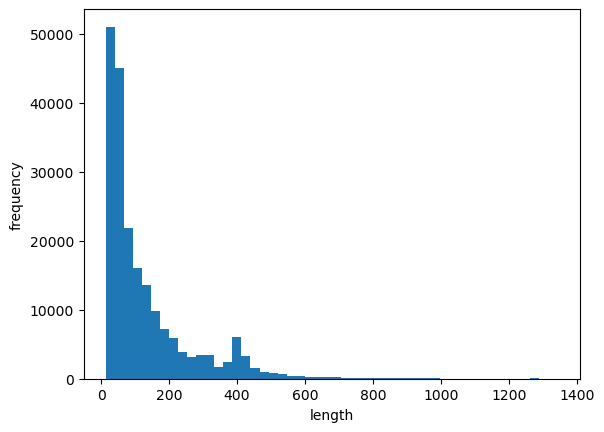

In [45]:
plt.figure()

plt.hist(lengths, bins = 50)

plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

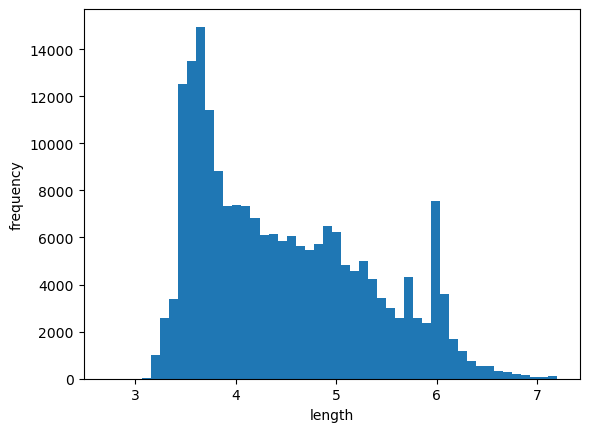

In [59]:
# 리뷰 길이에 로그 취함
plt.figure()

plt.hist(np.log(lengths), bins = 50)

plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

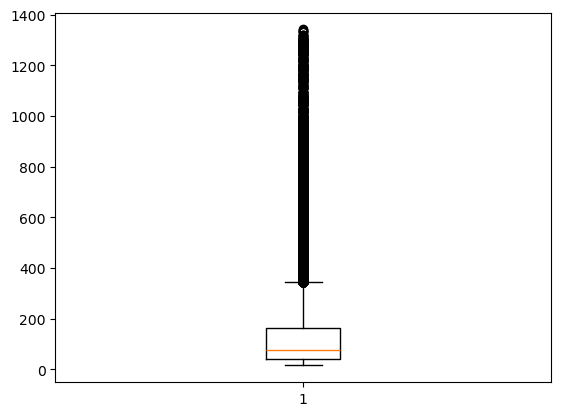

In [57]:
plt.boxplot(lengths)

plt.show()

In [47]:
long_review = []
for x in df["리뷰"]:
    if len(x) > 150:
        long_review.append(f"review: {x}")

    if len(long_review) == 10:
        break

print(long_review)

['review: 새치나 흰머리는 남 얘기로만 생각하고 살았던 지난날..지난 주 미용실에 가니 선생님께서 오잉 뒤쪽에 흰머리가 많이 나셨네요? 하시더라구요 평소 보이지않아 챙기지 못했던 내 뒤통수에게 미안한 마음이 들어 새치 케어 제품을 검색했습죠.염색을 하기에는 아직 이르다 싶었고 염색할때 마다 느끼는 눈 따가움을 피하고 싶어 모다모다 시도해봤어요 현재 3주차에 접어들었습니다! 거품내고 3분방치 설명서가 시키는대로 잘 따라하고 있습니다 제가 또 말은 잘듣거든요. 어쨌든 3주차부터 겉으로 보이던 새치가 갈색으로 조금씩 변하는 느낌? 이에요. 원래는 뒤통수에 보면 흰색으로 뿅 튀어나와서 눈에 띄던 새치 친구가 주변 머리색과 서서히 비슷해져가는????뭐야 리뷰를 쓰다보니까 신기하네요?회사에도 쓰고계신 분들이 있어서 얘기 들어보니 2-3달 열심히 쓰고 어느정도 색변화가 만족스럽다~싶으면 하루씩 번갈아 쓰기도 하시고..거품내기 전 샴푸 액상을 바르고 기다리시는 분들도 계시고..뭐랄까 민간요법들이 많더라구요 나름 재밌는것 같기도 하고ㅎㅎ지금까진 만족해요 6주차까지 열심히 써보겠습니다!', 'review: 저번에 샴푸 하나만 사서 썼는데 너무 만족해서그냥 2개 세트로 사버렸어요 ㅠ 사람마다 뭐 의견이 다르지만 저랑 우리 부모님은 진짜 대만족하면서 쓰고 있어용 특히 엄마가 염색에서 벗어났다고 진짜 좋아하세요 캬캬캬 사실 염색할 때마다 알러지나서 엄청 힘들어하셨거든요 2개 세트사서 더 좋아하심 ㅋㅋㅋㅋ써보니까 저랑 부모님이랑 약간 색이 변하는 속도가 좀 다르긴한데 결국은 다 색이 변하니까 꾸준하게 쓰는게 중요한거 같아요! 엄마는 엄청 빨리 되는데 저는 조금 더 걸려용 ㅋㅋㅋㅋ 유튜브에 보니까 뿌리 부분에 좀 바르고 기다리라고 해가지고 저도 그 방법 써보니 대만족! ㅋㅋㅋㅋㅋ염색약은 아니니까 바로 안되는 사람들은 이 방법 추천 ㅋㅋ거품도 풍성하게 나고 가끔 샴푸잘못 쓰면 가려울때가 있는데 저는 사실 두피가 민감하지 않아서 그런건 전혀 못 느꼈어요 샴푸 바뀌고 드라이할때 머리가

- maxlen 은 제3분위수와 비슷한 160정도 혹은 그 이상으로 잡아야 할 것으로 보임
    - 각 리뷰의 감성을 판단하는 게 아닌, 속성별 감성 분석이기 때문에 너무 짧게 자르면 각 속성의 문맥을 제대로 파악하지 못할까 우려
    - maxlen 여유 주기
 
- padding 은 시퀀스의 앞부분에 추가

- truncating 은 기본값으로 "pre"
    - 한국어 리뷰 데이터로 미괄식의 구조를 띄는 경향이 있음
    - 몇 개 확인해 봤을 때 다 그런 건 아니지만 맨 앞에는 구구절절 상황 설명하는 경우가 있음

- ** 첫번째 속성이 나오는 index 기준으로 리뷰 길이 분포 다시 확인
- 데이터 정제하고 리뷰 길이 분포 다시 보기

In [ ]:
# 토큰화한 리뷰 길이 분포
# 실행 없이 코드만 복붙
# df : 최종모델로 라벨링된 전체 데이터프레임 
from transformers import AutoModel, AutoConfig, AutoTokenizer

acd_tokenizer = AutoTokenizer.from_pretrained(acd_base_model)
asc_tokenizer = AutoTokenizer.from_pretrained(asc_base_model)

In [ ]:
# acd_tokenizer
acd_tokenized_len = []
for text in df["리뷰"]:
  acd_encoded = acd_tokenizer(
      text,
      padding=False,
      truncation=False,
      return_tensors='pt',
      add_special_tokens=True
          )

  input_ids = acd_encoded['input_ids'][0].tolist()
  acd_tokenized_len.append(len(input_ids))

In [ ]:
acd_lengths = np.array(acd_tokenized_len)
print(np.mean(acd_lengths), np.median(acd_lengths), np.min(acd_lengths), np.max(acd_lengths))
print(np.percentile(acd_lengths, 25), np.percentile(acd_lengths, 75))
# ans
# 50.647387690480905 30.0 3 559
# 17.0 63.0

In [ ]:
plt.figure()
sns.boxplot(data = acd_tokenized_len)

plt.show()

In [ ]:
plt.figure()

sns.histplot(acd_lengths, bins = 50)

plt.xlabel("acd_tokenized_length")
plt.ylabel("frequency")
plt.show()

In [ ]:
# asc_tokenizer
asc_tokenized_len = []
for text in df["리뷰"]:
  asc_encoded = asc_tokenizer(
      text,
      padding=False,
      truncation=False,
      return_tensors='pt',
      add_special_tokens=True
          )

  input_ids = asc_encoded['input_ids'][0].tolist()
  asc_tokenized_len.append(len(input_ids))

In [ ]:
asc_lengths = np.array(asc_tokenized_len)
print(np.mean(asc_lengths), np.median(asc_lengths), np.min(asc_lengths), np.max(asc_lengths))
print(np.percentile(asc_lengths, 25), np.percentile(asc_lengths, 75))
# ans
# 74.43400510147987 44.0 3 736
# 26.0 93.0

In [ ]:
plt.figure()
sns.boxplot(data = asc_tokenized_len)

plt.xlabel("asc_tokenized_length", fontsize = 15)

boxplot_path = os.path.join(DATA_DIR, 'maxlen_boxplot.png')
plt.savefig(boxplot_path, transparent = True)

plt.show()

In [ ]:
plt.figure()

plt.hist(asc_lengths, bins = 50)

plt.xlabel("asc_tokenized_length", fontsize = 15)
plt.ylabel("frequency", fontsize = 15)

hist_path = os.path.join(DATA_DIR, 'maxlen_hist.png')
plt.savefig(hist_path, transparent = True)

plt.show()

- maxlen = 128로 둬도 충분할듯
  - ACD f1: 0.9302
  - ABSA f1: 0.7757

- 같은 조건 하에 (data split 다시 x) maxlen = 256
  - ACD f1: 0.9277
  - ABSA f1: 0.7378

- maxlen = 128 일 때가 성능이 더 좋음

# 짧은 리뷰 제거

In [55]:
newdf[newdf["clean리뷰"].map(lambda x: len(x) == 0)]

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,작성자,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향,clean리뷰
846,라보에이치 두피쿨링&노세범샴푸 탈모증상완화 750ml+100ml 한정기획 / 단품,라보에이치,"36,000\n원","25,900\n원 ~","4,204",4.7,80%,12%,5%,1%,...,k202404173****,2025.04.20,添加彩色小颗粒，能增加和发丝间的摩擦，提高清洁力，可把油腻头发洗得很干净，让头皮清爽，发根立起，呈现蓬松感，大油头使用后能两三天不洗头。,5점만점에 5점,NaN,다소 아쉬워요,자극이 느껴져요,거품이 적어요,다소 아쉬워요,
3174,[5월 올영픽] 롱테이크 샴푸 300+100ML 기획 외 단품 2종 택 1,롱테이크,"24,000\n원","20,400\n원 ~","2,107",4.8,89%,8%,2%,1%,...,azx****,2025.05.15,用中文凑个十五字应该没人会发现吧嘿嘿哈哈呵呵呜呜嘻嘻,5점만점에 5점,NaN,보통이에요,자극이 느껴져요,거품이 적어요,보통이에요,
5080,[1등비듬가려움샴푸] 라우쉬 콜츠푸트 안티-댄드러프 샴푸 200ml 듀오 기획,라우쉬,"39,800\n원","31,500\n원","1,876",4.9,88%,10%,1%,0%,...,zhouzhou,2023.05.04,很喜欢的洗发水，去头皮屑效果很好，就是价格稍微有点贵，做活动买很好。,5점만점에 5점,NaN,다소 아쉬워요,자극이 느껴져요,거품이 적어요,다소 아쉬워요,
10559,[대용량] 바이오가 바이오틴 손상모발개선 탈모완화 샴푸 1000ml,바이오가,NaN,"27,500\n원","3,069",4.9,91%,6%,2%,0%,...,뮹먕묭몡,2025.04.21,👍🏻👩🏻🧴🫧👍🏻👃🏻👍🏻🤩😊🫰🏻,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,
15226,어노브 딥 데미지 리페어 샴푸 500g (단백질 앰플 샴푸),어노브,"18,000\n원","14,900\n원","4,848",4.8,87%,9%,3%,1%,...,k202111060****,2025.05.08,其实洗头膏不怎么感受得出区别但是这个用完之后确实感觉头发不像枯草了,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,
26053,라보에이치탈모증상완화샴푸 두피강화 리필팩 333ml*2입기획,라보에이치,"27,900\n원","21,900\n원","1,828",4.9,91%,8%,1%,0%,...,Helenwu,2023.12.02,挺好用的是不是卧槽卧槽真笑了好久不见不散的宴席。哈哈,5점만점에 5점,NaN,보통이에요,보통이에요,보통이에요,보통이에요,
34627,팬틴 극손상케어 샴푸/컨디셔너 750mL (2종 택1),팬틴,"18,900\n원","9,400\n원 ~","1,554",4.8,86%,11%,2%,0%,...,nili****,2025.01.20,趁打折的时候疯狂购入，好用，好评！以后在打折还会再买的！,5점만점에 5점,한달이상사용,보통이에요,보통이에요,보통이에요,보통이에요,
41001,[지성두피 & 쿨링] 클로란 아쿠아민트 딥클렌징 쿨링 샴푸 400ml,클로란,"26,000\n원","15,900\n원","5,142",4.6,70%,20%,7%,1%,...,pa8586,2020.05.08,♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡,5점만점에 5점,NaN,아주 만족해요,보통이에요,거품이 풍성해요,아주 만족해요,
41002,[지성두피 & 쿨링] 클로란 아쿠아민트 딥클렌징 쿨링 샴푸 400ml,클로란,"26,000\n원","15,900\n원","5,142",4.6,70%,20%,7%,1%,...,pa8586,2020.05.08,♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡,5점만점에 5점,NaN,아주 만족해요,보통이에요,거품이 풍성해요,아주 만족해요,
82910,[지성두피 & 쿨링] 클로란 아쿠아민트 샴푸 더블 기획 (400ml+400ml),클로란,"39,000\n원","26,900\n원","5,268",4.6,70%,20%,7%,1%,...,pa8586,2020.05.08,♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡♡,5점만점에 5점,NaN,아주 만족해요,보통이에요,거품이 풍성해요,아주 만족해요,


In [56]:
newdf[newdf["clean리뷰"].map(lambda x: len(x) == 1)]

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,작성자,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향,clean리뷰
34662,팬틴 극손상케어 샴푸/컨디셔너 750mL (2종 택1),팬틴,"18,900\n원","9,400\n원 ~","1,554",4.8,86%,11%,2%,0%,...,nili****,2024.11.25,很好用，很不错~ 在朋友的推荐下买的，以后有机会回购,5점만점에 5점,NaN,보통이에요,보통이에요,보통이에요,보통이에요,~
77142,[헤어필러] 라보에이치 모발강화 샴푸 430ml+50ml 한정기획/ 단품 택 1,라보에이치,"20,000\n원","14,400\n원 ~",171,4.7,82%,10%,6%,0%,...,KimYuliya,2025.04.29,"Цена была дешевле чем на купанге,это радует",5점만점에 4점,NaN,보통이에요,보통이에요,보통이에요,보통이에요,","
134925,[탈모증상완화/두피항산화] 아로마티카 탈모증상완화 로즈마리 스칼프 스크럽 165g,아로마티카,"20,000\n원","16,000\n원","1,592",4.6,72%,19%,7%,1%,...,마리야,2023.11.11,"Не увидела результата , маленький объем",5점만점에 5점,한달이상사용,보통이에요,보통이에요,보통이에요,보통이에요,","
134929,[탈모증상완화/두피항산화] 아로마티카 탈모증상완화 로즈마리 스칼프 스크럽 165g,아로마티카,"20,000\n원","16,000\n원","1,592",4.6,72%,19%,7%,1%,...,마리야,2023.08.19,"Хороший запах и эффект свежести , только объем маленький (",5점만점에 4점,NaN,보통이에요,보통이에요,보통이에요,보통이에요,","
158304,[대용량] 바디브 약산성 미용실 퍼퓸 샴푸 [비듬 가려움 개선] 5종 택 1,바디브,"15,900\n원","14,900\n원 ~",275,4.9,96%,3%,1%,0%,...,jjka****,2025.03.16,"купил для друга, не пробовали но посмотрим еще",5점만점에 5점,NaN,보통이에요,보통이에요,보통이에요,보통이에요,","


In [57]:
newdf[newdf["clean리뷰"].map(lambda x: len(x) == 2)]

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,작성자,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향,clean리뷰
188321,[두피케어] 닥터포헤어 피토테라피 민감두피 진정샴푸 300ml (NEW),닥터포헤어,"22,000\n원","15,900\n원","3,243",4.6,74%,20%,6%,1%,...,ohs****,2020.05.17,굿!!!!!!!!!!!!!!!!!!!!!!!!!!!!,5점만점에 4점,NaN,보통이에요,보통이에요,보통이에요,보통이에요,굿!


In [58]:
newdf[newdf["clean리뷰"].map(lambda x: len(x) == 3)]

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,작성자,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향,clean리뷰
19649,[NEW] 미쟝센 퍼펙트 매직 스트레이트 샴푸/트리트먼트/세럼 3종 중 택1,미쟝센,"15,000\n원","11,900\n원 ~","1,843",4.6,76%,14%,7%,2%,...,k202305127****,2024.11.28,Шампунь понравился. Волосы мягкие. Отдушка не сильная и приятная,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,. .
19650,[NEW] 미쟝센 퍼펙트 매직 스트레이트 샴푸/트리트먼트/세럼 3종 중 택1,미쟝센,"15,000\n원","11,900\n원 ~","1,843",4.6,76%,14%,7%,2%,...,k202305127****,2024.11.28,Хороший кондиционер для волос. Приятный запах~,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,. ~
49013,헤드앤숄더 샴푸 520ml 2입 기획 4종 택 1,헤드앤숄더,NaN,"19,900\n원 ~",337,4.9,92%,6%,2%,0%,...,k202408188****,2025.04.27,Классный шампунь. Обожаю. Спасибо большое,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,. .
77525,알페신 카페인샴푸 C1 250ml,알페신,NaN,"14,000\n원",301,4.8,89%,8%,2%,0%,...,eli****,2023.12.05,"Мужу очень понравился этот шампунь, уже заказал вторую упаковку^^~",5점만점에 5점,한달이상사용,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,", ~"
77536,알페신 카페인샴푸 C1 250ml,알페신,NaN,"14,000\n원",301,4.8,89%,8%,2%,0%,...,eli****,2023.11.05,"Мужу очень понравился этот шампунь, уже заказал вторую упаковку^^~",5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,", ~"
88088,라우쉬 샴푸 200ml 5종 택1 (콜츠푸트/씨위드/스위스허벌/카모마일/에그오일),라우쉬,"26,000\n원","21,500\n원 ~","5,231",4.7,81%,15%,4%,1%,...,wishisdo****,2024.01.26,Шампунь очень хороший 90% натуральные ингредиенты,5점만점에 5점,NaN,다소 아쉬워요,자극이 느껴져요,거품이 적어요,다소 아쉬워요,90%
167524,알페신 카페인샴푸 C1 375ml 기획 세트(+리퀴드 75ml+펌프),알페신,NaN,"24,000\n원",727,4.8,88%,9%,2%,0%,...,eli****,2023.12.05,"Мужу очень понравился этот шампунь, уже заказал вторую упаковку^^~",5점만점에 5점,한달이상사용,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,", ~"
167543,알페신 카페인샴푸 C1 375ml 기획 세트(+리퀴드 75ml+펌프),알페신,NaN,"24,000\n원",727,4.8,88%,9%,2%,0%,...,eli****,2023.11.05,"Мужу очень понравился этот шампунь, уже заказал вторую упаковку^^~",5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,", ~"
175186,[입체볼륨샴푸]라우쉬 멜로우 볼륨 샴푸 200ml,라우쉬,"26,000\n원","23,400\n원",984,4.8,84%,10%,4%,1%,...,wishisdo****,2024.01.26,Шампунь очень хороший 90% натуральные ингредиенты,5점만점에 5점,NaN,다소 아쉬워요,자극이 느껴져요,거품이 적어요,다소 아쉬워요,90%


In [59]:
newdf[newdf["clean리뷰"].map(lambda x: len(x) == 4)]

,제품명,브랜드,원가,판매가,리뷰수,평균별점,5점비율,4점비율,3점비율,2점비율,...,작성자,작성일자,리뷰,별점,사용현황,세정력,자극도,거품,향,clean리뷰
122748,[손상 & 건조모발] 클로란 망고버터 데미지 리페어 샴푸 400ml,클로란,"26,000\n원","16,900\n원","1,043",4.6,70%,20%,7%,1%,...,wkdus****,2020.06.11,좋아욥!!!!!!!!!!!!!!!!!!!!!!!!,5점만점에 5점,NaN,보통이에요,보통이에요,보통이에요,보통이에요,좋아욥!
184575,착한팩토리 밀크 단백질샴푸 1000ml+트리트먼트 1000ml,착한팩토리,NaN,"22,000\n원","1,506",4.5,68%,21%,8%,2%,...,란,2020.01.16,Good。。。。。。。。。。。。。。。。。。。。。。。,5점만점에 5점,NaN,아주 만족해요,자극없이 순해요,거품이 풍성해요,아주 만족해요,Good


In [ ]:
# clean리뷰의 길이 통계값
lengths = np.array([len(x) for x in df["clean리뷰"]])
print(np.mean(lengths), np.median(lengths), np.min(lengths), np.max(lengths))
print(np.percentile(lengths, 25), np.percentile(lengths, 75))

In [47]:
drop_idx = df[df["clean리뷰"].map(lambda x: len(x) <= 3)].index
df = df.drop(drop_idx, axis = 0)

In [49]:
df.shape

(204920, 34)

In [51]:
df["리뷰"].head(20)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [53]:
df["clean리뷰"].head(20)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       일주일째 쓰는중인데 좋은거 같기도하고 아닌것 같기도 하고 한달뒤 후기로..ㄹ
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                    